# Conversion SR532' à partir de SR355 
--------------------------------------------------------


In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

------------------------------

In [4]:
def remove_NaN_Inf_values(arrayX, arrayY):
    idsX = np.where(~np.isnan(arrayX)&~np.isinf(arrayX))[0]
    idsY = np.where(~np.isnan(arrayY)&~np.isinf(arrayY))[0]
    mask = np.union1d(idsX, idsY)
    return mask

def get_params_histogram(srlimite, Xdata, Ydata):
    from scipy import stats
    from scipy.optimize import curve_fit
    # objective function for best fit
    def objective(x, a, b):
        return a * x + b
    
#     if (~np.isnan(Xdata)|~np.isinf(Xdata)).sum() > (~np.isnan(Ydata)|~np.isinf(Ydata)).sum():
    mask = remove_NaN_Inf_values(Xdata, Ydata)
    print('A')
    H = np.histogram2d(Xdata[mask], Ydata[mask], bins=100, range = srlimite)
    Hprobas = H[0]*100/len(Ydata[mask])
    noNaNpoints = len(Ydata[mask])
    # create the curve fit
    param, param_cov = curve_fit(objective, Xdata[mask], Ydata[mask])
    print(param, param_cov)

    print(f'nombre de points no-NaN: {noNaNpoints}')
    xedges, yedges = np.meshgrid(H[1], H[2])
#     print(slope, intercept)
#     fitLine = slope * allsr532 + intercept
    return xedges, yedges, Hprobas, param

In [5]:
def find_nearest_time(time_array, value):
    time_array = pd.to_datetime(time_array)
    idt = (np.abs(time_array - pd.to_datetime(value))).argmin()
    time_value = time_array[idt]
    return idt, time_value

# Create KFold Cross-validation and Training model

In [6]:
def add_feature(data_before, adding):
    if (len(data_before.shape)<2):
        data_before = data_before.reshape(-1,1)
    if (len(adding.shape)<2):
        adding = adding.reshape(-1,1)
        
    print(f'Updating shape: {data_before.shape}, {adding.shape}')        
    data_after = np.hstack((data_before, adding))
    print(f'shape of data after adding feature: {data_after.shape}')
    if data_after.shape[1]>1:
        return data_after
    else:
        print('Error')
        return 1

def performance_val(Xinput_val, Yinput_val, Ypred_val):
    residus_val = Yinput_val - Ypred_val
    stats_residus_val = pd.DataFrame(residus_val).describe()#[['mean', 'std']]
    return stats_residus_val #mean_residus, std_residus

def DecisionTree_model(Xinput_train, Yinput_train, Xinput_val, Yinput_val):#
    from sklearn.tree import DecisionTreeRegressor as DTR
    tree = DTR(min_samples_leaf=5)
    tree = tree.fit(Xinput_train, Yinput_train)
    Ypred_val = tree.predict(Xinput_val)
    stats_residus_val = performance_val(Xinput_val, Yinput_val, Ypred_val)
#     print(f'Mean of residus = {mean_residus}')
#     print(f'STD of residus = {std_residus}')
    return Ypred_val, stats_residus_val, tree

def LinearRgression_model(Xinput_train, Yinput_train, Xinput_val, Yinput_val):
    from sklearn.linear_model import LinearRegression as LR
    LRmodel = LR(fit_intercept=True)
    LRmodel = LRmodel.fit(Xinput_train, Yinput_train)
    Ypred_val = LRmodel.predict(Xinput_val)
    stats_residus_val = performance_val(Xinput_val, Yinput_val, Ypred_val)
    return Ypred_val, stats_residus_val, LRmodel

### Dataset and Parameters

In [7]:
# DATASET
#--------
pattern = ['/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr',
          '__xarray_dataarray_variable__']

# allsr355 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allatb355-3000-4000.nc')['__xarray_dataarray_variable__'].values
# allsr532 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allatb532-3000-4000.nc')['__xarray_dataarray_variable__'].values

allsr355 = xr.open_dataset(f'{pattern[0]}355-3000-4000.nc')[pattern[1]].values
allsr532 = xr.open_dataset(f'{pattern[0]}532-3000-4000.nc')[pattern[1]].values

# PARAMETERS
#-----------
alt = xr.open_dataset(f'{pattern[0]}355-3000-4000.nc')['range'].values
time = xr.open_dataset(f'{pattern[0]}355-3000-4000.nc')['time'].values

In [41]:
alt 

array([ 3015.,  3030.,  3045.,  3060.,  3075.,  3090.,  3105.,  3120.,
        3135.,  3150.,  3165.,  3180.,  3195.,  3210.,  3225.,  3240.,
        3255.,  3270.,  3285.,  3300.,  3315.,  3330.,  3345.,  3360.,
        3375.,  3390.,  3405.,  3420.,  3435.,  3450.,  3465.,  3480.,
        3495.,  3510.,  3525.,  3540.,  3555.,  3570.,  3585.,  3600.,
        3615.,  3630.,  3645.,  3660.,  3675.,  3690.,  3705.,  3720.,
        3735.,  3750.,  3765.,  3780.,  3795.,  3810.,  3825.,  3840.,
        3855.,  3870.,  3885.,  3900.,  3915.,  3930.,  3945.,  3960.,
        3975.,  3990.,  4005.,  4020.,  4035.,  4050.,  4065.,  4080.,
        4095.,  4110.,  4125.,  4140.,  4155.,  4170.,  4185.,  4200.,
        4215.,  4230.,  4245.,  4260.,  4275.,  4290.,  4305.,  4320.,
        4335.,  4350.,  4365.,  4380.,  4395.,  4410.,  4425.,  4440.,
        4455.,  4470.,  4485.,  4500.,  4515.,  4530.,  4545.,  4560.,
        4575.,  4590.,  4605.,  4620.,  4635.,  4650.,  4665.,  4680.,
      

In [38]:
mat_alt = np.tile(alt, (allsr355.shape[0],1))
mat_time = np.tile(time, (allsr355.shape[1], 1)).T

print(mat_alt.shape, mat_time.shape)


(5597, 799) (5597, 799)


------------------

In [41]:
from sklearn.model_selection import train_test_split, ShuffleSplit

data = add_feature(allsr355.ravel(), mat_alt.ravel())
target = allsr532.ravel()

# clean data, target from Nan/negative values 
#--------------------------------------------

mask = np.logical_and(~np.isnan(data[:, 0]), ~np.isnan(target))
data = data[mask, :]
target = target[mask]


# split data training & testing
#------------------------------
cv = ShuffleSplit(n_splits=5, test_size=0.35)

Updating shape: (4472003, 1), (4472003, 1)
shape of data after adding feature: (4472003, 2)


In [61]:
(data[:,0] < 0).sum()/len(data[:,0]) *100, (target<0).sum()/len(target)

(1.8250458048213212, 0.014052536897327945)

In [56]:
# create model : Decision Tree Regression
#----------------------------------------

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

preprocessor = StandardScaler()
modelp = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=7))

In [53]:
modelp['decisiontreeregressor']

DecisionTreeRegressor(max_depth=7)

In [43]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True, n_jobs=2)

cv_results = pd.DataFrame(cv_results)
# cv_results


KeyboardInterrupt: 

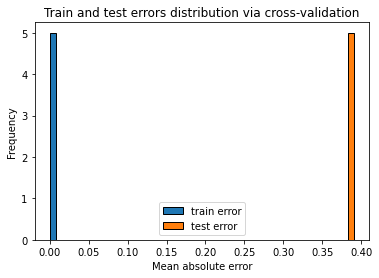

In [17]:
# Scores of Cross validation 
#---------------------------

scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[["train_score", "test_score"]]

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error")
_ = plt.title("Train and test errors distribution via cross-validation")

In [48]:
from sklearn.model_selection import validation_curve, learning_curve

max_depth = [3, 5, 7]
min_sample_leaf = [1,2,3,4,5]
min_sample_split = [3, 5, 7]
train_scores, test_scores = validation_curve(model, data, target, cv=cv,
            param_name = 'min_samples_split', param_range=min_sample_split,
            scoring='neg_mean_absolute_error', n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores

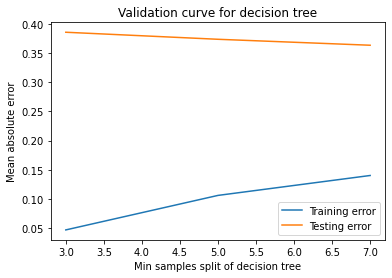

In [49]:
plt.plot(min_sample_split, train_errors.mean(axis=1), label="Training error")
plt.plot(min_sample_split, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Min samples split of decision tree")
plt.ylabel("Mean absolute error")
_ = plt.title("Validation curve for decision tree")
plt.savefig('/home/nmpnguyen/conversion_model/validation_curve_decision_tree_alldata3.png')

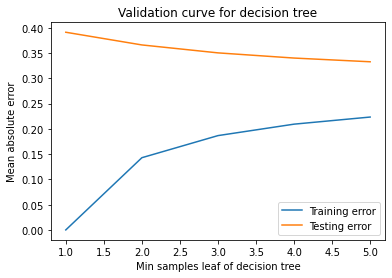

In [46]:
plt.plot(min_sample_leaf, train_errors.mean(axis=1), label="Training error")
plt.plot(min_sample_leaf, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Min samples leaf of decision tree")
plt.ylabel("Mean absolute error")
_ = plt.title("Validation curve for decision tree")
plt.savefig('/home/nmpnguyen/conversion_model/validation_curve_decision_tree_alldata2.png')

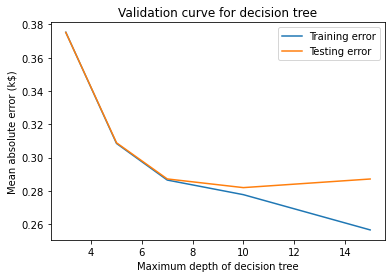

In [20]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error")
_ = plt.title("Validation curve for decision tree")
plt.savefig('/home/nmpnguyen/conversion_model/validation_curve_decision_tree_alldata.png')

In [31]:
model = DecisionTreeRegressor(max_depth=7)

mask = np.logical_and(data[:,0]>0, target>0)
data = data[mask, :]
target = target[mask]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.35)

model = model.fit(data_train, target_train)
data_predict = model.predict(data_test)

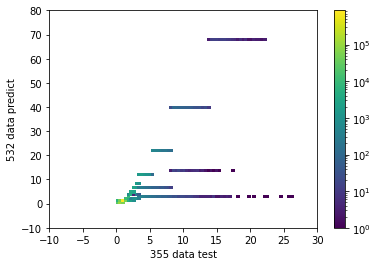

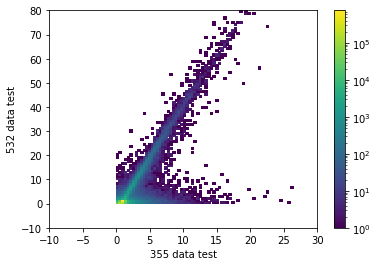

In [32]:
fig, ax = plt.subplots()
h = ax.hist2d(data_test[:,0], data_predict, range=[[-10,30], [-10,80]], bins=100, norm=LogNorm())
ax.set(xlabel='355 data test', ylabel='532 data predict')
plt.colorbar(h[3], ax=ax)


fig, ax = plt.subplots()
h = ax.hist2d(data_test[:,0], target_test, range=[[-10,30], [-10,80]], bins=100, norm=LogNorm())
ax.set(xlabel='355 data test', ylabel='532 data test')
plt.colorbar(h[3], ax=ax)

In [29]:
data_predict.shape

(1263459,)

--------------------------

In [54]:
# sélectionner à apprentissage à partir des valeurs négatives 
#------------------------------------------------------------

# mask = np.logical_and(allsr355 <0, allsr532 <0)
# allsr355 = allsr355[mask]
# allsr532 = allsr532[mask]

# mat_alt = mat_alt[mask]
# mat_time = mat_time[mask]

In [55]:
from sklearn.model_selection import train_test_split

allsr355_after = add_feature(allsr355.ravel(), mat_alt.ravel())
allsr532_after = allsr532.ravel()

mask = remove_NaN_Inf_values(allsr355_after[:,0], allsr532_after)
allsr355_after = allsr355_after[mask,:]
allsr532_after = allsr532_after[mask]
mask = np.logical_and(allsr355_after[:,0]>0, allsr532_after>0)
allsr355_after = allsr355_after[mask,:]
allsr532_after = allsr532_after[mask]

allsr355_train, allsr355_test, allsr532_train, allsr532_test = train_test_split(allsr355_after, allsr532_after, 
                                                                                test_size=0.35, random_state=0)
print(allsr355_train.shape, allsr532_test.shape)

Updating shape: (4472003, 1), (4472003, 1)
shape of data after adding feature: (4472003, 2)
(2278881, 2) (1227090,)


AttributeError: 'Rectangle' object has no property 'kwargs'

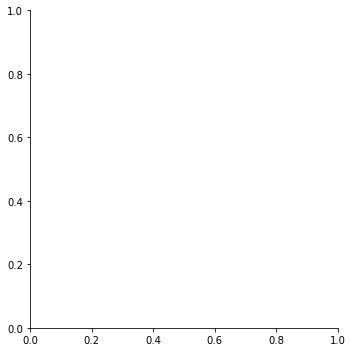

In [18]:
# Générer la distribution normale accumulée du dataset
#-----------------------------------------------------

import seaborn as sns 
sns.displot(pd.Series(allsr355_train[:,0]), stat='probability', kind='hist',
            kwargs={'cumulative':True, 'binrange':[-10,80]},
            kde_kws={'cumulative':True})
 

(1709160, 2) (1709160,)
(1709161, 2) (1709161,)
(1709161, 2) (1709161,)
(1709161, 2) (1709161,)


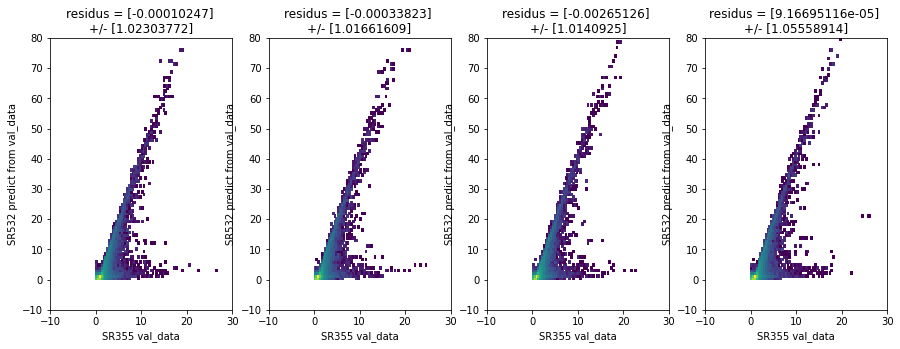

In [56]:
from sklearn.model_selection import KFold
n_splits = 4
kf = KFold(n_splits=n_splits)

Fig, axs = plt.subplots(ncols=n_splits, figsize=(15,5))
for (id_train, id_val), (i, ax) in zip(kf.split(allsr355_train), enumerate(axs.flat)):
    XFold_train, YFold_train = allsr355_train[id_train,:], allsr532_train[id_train]
    XFold_val, YFold_val = allsr355_train[id_val,:], allsr532_train[id_val]
    print(XFold_train.shape, YFold_train.shape)
    # decision tree
    #--------------
#     sr532_pred, stat_residus, treemodel = DecisionTree_model(XFold_train, YFold_train, XFold_val, YFold_val)
#     ax.hist2d(XFold_val[:,0], sr532_pred, bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm())
#     ax.set(xlabel='SR355 val_data', ylabel='SR532 predict from val_data',
#            title=f"residus = {stat_residus.loc['mean'].values} \n+/- {stat_residus.loc['std'].values}")
    #linear regression
    #--------------
#     sr532_pred, stat_residus, lr_model = LinearRgression_model(XFold_train, YFold_train, XFold_val, YFold_val)
#     ax.hist2d(XFold_val[:,0], sr532_pred, bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm()) #range=[[-10,30], [-10, 80]], 
#     ax.set(xlabel='SR355 val_data', ylabel='SR532 predict from val_data',
#            title=f"residus = {stat_residus.loc['mean'].values} \n+/- {stat_residus.loc['std'].values}")
#     print(lr_model.coef_)

In [57]:
fullsr532_predict, full_stast, treemodel_full = DecisionTree_model(allsr355_train, allsr532_train, allsr355_test, allsr532_test)
# fullsr532_predict, full_stast, lrmodel_full = LinearRgression_model(allsr355_train, allsr532_train, allsr355_test, allsr532_test)

In [59]:
treemodel_full.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

### Test pre-pruning of Decision Tree  

In [62]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import GridSearchCV 

param_grid = {
    "max_depth": [3,5,10,15],
#     "min_samples_split": [5,7,10],
#     "min_samples_leaf": [5,7,10],
#     "min_impurity_split": [-5.0, -1.0, 0.0]
}
clf = DTC(splitter = 'best', random_state=None)
# grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", cv=4).fit(allsr355_train, allsr532_train)

In [63]:
grid_cv = GridSearchCV(clf, param_grid, cv=4).fit(allsr355_train, allsr532_train)

/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 181, in fit
    check_classification_targets(y)
  File "/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings

/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 181, in fit
    check_classification_targets(y)
  File "/net/nfs/tools/python-anaconda/3.8/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings

ValueError: Unknown label type: 'continuous'

In [20]:
# import pickle

# pickle.dump(lrmodel_full, open('/home/nmpnguyen/conversion_model/lrmodel_atb.sav', 'wb'))
# pickle.dump(treemodel_full, open('/home/nmpnguyen/conversion_model/treemodel_sr_positive.sav', 'wb'))

In [10]:
def scatterplot_predict_target(MLmodel, datatrain, targettrain, 
                               datatest, targettest, 
                               predicttrain, predicttest, 
                               scores, params_plots):
    ranges = params_plots['ranges']#[[-0.5,30], [-0.5, 80]]
    titles = params_plots['titles'] #y compris dataset, size of data train/test, model name
    norm = params_plots['norms']
    feature = params_plots['feature_position']
    bins = params_plots['bins']

    
    fg, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,15))
    h0 = axs[0,0].hist2d(datatrain[:,feature], targettrain, bins=bins, range=ranges, norm=norm)
    axs[0,0].set(xlabel='ATB355 train_data', ylabel='ATB532 train_data',
       title=f'{titles[0]}')
    plt.colorbar(h0[3], ax=axs[0,0])

    h1 = axs[0,1].hist2d(datatest[:,feature], targettest, bins=bins, range=ranges, norm=norm)
    axs[0,1].set(xlabel='ATB355 test_data', ylabel='ATB532 test_data',
       title=f'{titles[1]}')
    plt.colorbar(h1[3], ax=axs[0,1])

    h2 = axs[0,2].hist2d(datatrain[:,feature], predicttrain, bins=bins, range=ranges, norm=norm)
    axs[0,2].set(xlabel='ATB355 train_data', ylabel='ATB532 predict from train_data',
       title=f'{titles[2]}')        
    plt.colorbar(h2[3], ax=axs[0,2])
    
    h3 = axs[1,0].hist2d(datatest[:,feature], predicttest, bins=bins, range=ranges, norm=norm)
    axs[1,0].set(xlabel='ATB355 test_data', ylabel='ATB532 predict from test_data',
       title=f'{titles[3]}')  
    plt.colorbar(h3[3], ax=axs[1,0])

    h4 = axs[1,1].hist2d(datatest[:,feature], targettest - predicttest, bins=bins, range=ranges, norm=norm)
    axs[1,1].set(xlabel='ATB355 test_data', ylabel='residus = ATB532 - ATB532pred',
       title=f'{titles[4]}')
    plt.colorbar(h4[3], ax=axs[1,1])
    
    scores['train_score'], scores['test_score'] = -scores['train_score'], -scores['test_score']
    scores = scores.reset_index()
    scores.plot(x='index', y='test_score', label='test_scores', ax=axs[1,2])
    scores.plot(x='index', y='train_score', label='train_scores', ax=axs[1,2])
    axs[1,2].legend()
    axs[1,2].set(xlabel = 'n_splits', ylabel='mean absolute error',
        title=f'{titles[5]}')
    
    plt.suptitle(f'{MLmodel}')
    return 1

In [96]:
# plt.hist(fullsr532_predict, range=[-0.5,5])


# TESTING WITH 3TH FEATURE

In [6]:
# DATASET
#--------
pattern = ['/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr',
          '__xarray_dataarray_variable__']

# allsr355 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allatb355-3000-4000.nc')['__xarray_dataarray_variable__'].values
# allsr532 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allatb532-3000-4000.nc')['__xarray_dataarray_variable__'].values

allsr355 = xr.open_dataset(f'{pattern[0]}355-3000-4000.nc')[pattern[1]].values
allsr532 = xr.open_dataset(f'{pattern[0]}532-3000-4000.nc')[pattern[1]].values

# PARAMETERS
#-----------
alt = xr.open_dataset(f'{pattern[0]}355-3000-4000.nc')['range'].values
time = xr.open_dataset(f'{pattern[0]}355-3000-4000.nc')['time'].values

In [7]:
mat_alt = np.tile(alt, (allsr355.shape[0],1))
mat_time = np.tile(time, (allsr355.shape[1], 1)).T

print(mat_alt.shape, mat_time.shape)


(5597, 799) (5597, 799)


Text(0.5, 1.0, 'allsr355[allsr355>1], allsr532[allsr355>1]')

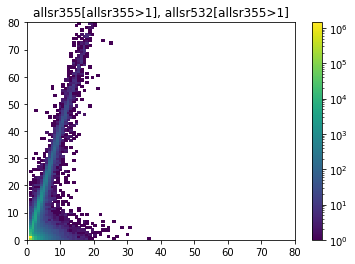

In [8]:
#---------------
plt.hist2d(allsr355[allsr355>1], allsr532[allsr355>1], norm=LogNorm(), range=[[0,80], [0,80]], bins=100)
plt.colorbar()
plt.title('allsr355[allsr355>1], allsr532[allsr355>1]')

In [13]:
allsr355_after = add_feature(allsr355.ravel(), mat_alt.ravel())
# 3e feature of X
from tqdm import tqdm
X3 = np.zeros(mat_alt.shape)
print(X3.shape)
X3[0,:] = np.nan
for j in tqdm(range(1, mat_alt.shape[1])):
    X3[:,j] = X3[:,j-1] + allsr355[:,j]*(mat_alt[:,j] - mat_alt[:,j-1])
print(X3)
allsr355_after = add_feature(allsr355_after, X3.ravel())

allsr532_after = allsr532.ravel()

mask = np.logical_and(~np.isnan(allsr355_after[:,0]), ~np.isnan(allsr355_after[:,2]), ~np.isnan(allsr532_after)) # 
# mask = remove_NaN_Inf_values(allsr355_after[:,0], allsr532_after)
allsr355_after = allsr355_after[mask,:]
allsr532_after = allsr532_after[mask]

from sklearn.model_selection import train_test_split, ShuffleSplit
cv = ShuffleSplit(test_size=0.25)
data_train, data_test, target_train, target_test = train_test_split(allsr355_after, allsr532_after, 
                                                                                test_size = 0.25, random_state=0)
print(f'shape of data train et data test {data_train.shape, data_test.shape}')



  0%|          | 0/798 [00:00<?, ?it/s]

Updating shape: (4472003, 1), (4472003, 1)
shape of data after adding feature: (4472003, 2)
(5597, 799)


100%|██████████| 798/798 [00:03<00:00, 259.13it/s]


[[           nan            nan            nan ...            nan
             nan            nan]
 [0.00000000e+00 1.25487346e+01 2.51963480e+01 ... 1.43066175e+04
  1.43220188e+04 1.43370594e+04]
 [0.00000000e+00 1.21459576e+01 2.44011056e+01 ... 1.47163779e+04
  1.47325636e+04 1.47491464e+04]
 ...
 [0.00000000e+00 1.55549541e+01 3.11704518e+01 ... 1.04857968e+04
  1.04692763e+04 1.04606750e+04]
 [0.00000000e+00 1.57109219e+01 3.11052995e+01 ... 1.04339807e+04
  1.03915457e+04 1.04056847e+04]
 [0.00000000e+00 1.54668749e+01 3.15722532e+01 ... 9.66172904e+03
  9.66337516e+03 9.69355604e+03]]
Updating shape: (4472003, 2), (4472003, 1)
shape of data after adding feature: (4472003, 3)
shape of data train et data test ((2706812, 3), (902271, 3))


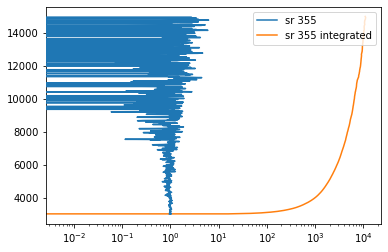

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.semilogx(allsr355[500,:], alt, label='sr 355', zorder=10)
ax.semilogx(X3[500,:], alt, label='sr 355 integrated')
ax.legend(loc='upper right')
# ax.set_xlim(1e-1, 1e3)

In [17]:
import pickle

allsr355_after = pd.DataFrame(allsr355_after)
allsr355_after.to_csv('/home/nmpnguyen/conversion_model/X.csv')

allsr532_after = pd.DataFrame(allsr532_after)
allsr532_after.to_csv('/home/nmpnguyen/conversion_model/Y.csv')

In [14]:
# StandardScaler data
#--------------------
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

preprocessor = StandardScaler()

model = make_pipeline(preprocessor, DecisionTreeRegressor())
model.fit(data_train, target_train)

cv_results = cross_validate(model, data_train, target_train, cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True, n_jobs=2)

cv_results = pd.DataFrame(cv_results)
print(cv_results)
print(model.get_params())

In [17]:
(-cv_results['test_score']).mean(), (-cv_results['test_score']).std()
(-cv_results['train_score']).mean(), (-cv_results['train_score']).std()

(1.6185386737620977e-07, 5.292604943869851e-08)

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# training without preprocessing
#-------------------------------
model = DecisionTreeRegressor()
# max_depth=15, min_samples_split=70, min_samples_leaf=15
model.fit(data_train, target_train)

# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth' : (3, 7, 15, 30),
#     'min_samples_leaf' : (5, 10, 15, 20, 30),
# }

# model_grid_search = GridSearchCV(
#     model, param_grid=param_grid, n_jobs=2, cv=10
# )

# model_grid_search.fit(data_train, target_train)
# model_grid_search.best_param_

from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data_train, target_train, cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True, n_jobs=2)

cv_results = pd.DataFrame(cv_results)
print(cv_results)
print(model.get_params())

    fit_time  score_time  test_score   train_score
0  59.576541    0.997489   -0.352337 -3.244191e-07
1  61.938273    0.980762   -0.351095 -3.760959e-07
2  58.099488    0.997177   -0.352651 -2.621503e-07
3  57.332320    0.993047   -0.351416 -3.358463e-07
4  59.660353    0.987817   -0.349899 -2.190519e-07
5  60.505885    1.016891   -0.353597 -2.691021e-07
6  63.487948    0.982963   -0.352539 -2.807917e-07
7  57.513447    0.975038   -0.351273 -3.150210e-07
8  67.562508    1.005438   -0.353592 -2.774582e-07
9  72.798588    1.009986   -0.350561 -2.747779e-07
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


In [15]:
data_predicttest = model.predict(data_test)
data_predicttrain = model.predict(data_train)
params_plot = {
    'titles' : ['1.Ipral train dataset size=0.75', '2.Test dataset size=0.25', '3.Prediction on train dataset', 
                '4.Prediction on test dataset', '5.Residus', '6.Mean absolute error'],
    'bins' : 100,
    'norms' : LogNorm(),
    'ranges': [[-10,30], [-10,80]],
    'feature_position':0
}
# scatterplot_predict_target(model, data_train, target_train, data_test, target_test,
#                           data_predicttrain, data_predicttest, cv_results, params_plot)

In [18]:
pd.DataFrame(data_train).to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison', 'ipral_2018_learned_train_dataset.pkl'))
pd.DataFrame(data_test).to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison', 'ipral_2018_learned_TEST_dataset.pkl'))
pd.DataFrame(target_train).to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison', 'ipral_2018_learned_traintarget_dataset.pkl'))
pd.DataFrame(target_test).to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison', 'ipral_2018_learned_TESTtarget_dataset.pkl'))
pd.DataFrame(data_predicttest).to_pickle(Path('/home/nmpnguyen/conversion_model/comparaison', 'ipral_2018_learned_TESTpredict_dataset.pkl'))

[Text(0.5, 0, 'SR355'), Text(0, 0.5, '<e> +/- std(e)')]

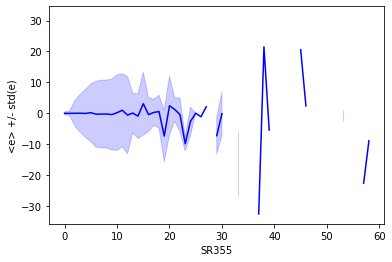

In [109]:
pd_classed = pd.DataFrame(np.concatenate([data_test, target_test.reshape(-1,1), data_predicttest.reshape(-1,1)], axis=1), 
                          columns = ['sr355', 'alt', 'sr532', 'sr532_predicted'])
pd_classed['absolute_error'] = (pd_classed['sr532'] - pd_classed['sr532_predicted'])

pd_classed

pd_classed['mesures_range'] = pd.cut(pd_classed['sr355'], pd.interval_range(start=0, end=60, freq=1))
pd_mean = pd_classed.groupby('mesures_range').agg({'absolute_error': lambda x: x.mean(skipna=True)})['absolute_error']
pd_std = pd_classed.groupby('mesures_range').agg({'absolute_error': lambda x: x.std(skipna=True)})['absolute_error']

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.arange(0,60,1), pd_mean, 'b-')
ax.fill_between(np.arange(0,60,1), pd_mean+pd_std, pd_mean-pd_std, color='b', alpha=0.2)
ax.set(xlabel='SR355', ylabel='<e> +/- std(e)')

[Text(0.5, 0, 'Altitude'), Text(0, 0.5, '<e> +/- std(e)')]

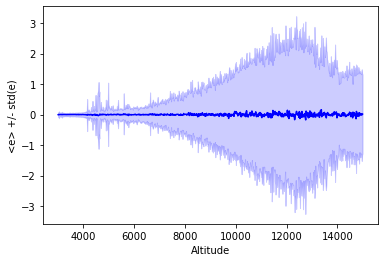

In [111]:
pd_mean = pd_classed.groupby('alt').agg({'absolute_error': lambda x: x.mean(skipna=True)})['absolute_error']
pd_std = pd_classed.groupby('alt').agg({'absolute_error': lambda x: x.std(skipna=True)})['absolute_error']


fig, ax = plt.subplots()
ax.plot(pd_mean.reset_index()['alt'], pd_mean, 'b-')
ax.fill_between(pd_mean.reset_index()['alt'], pd_mean+pd_std, pd_mean-pd_std, color='b', alpha=0.2)
ax.set(xlabel='Altitude', ylabel='<e> +/- std(e)')
# ax.set_xlim(0,15000)

In [112]:
pd_classed['mesures_range'] = pd.cut(pd_classed['sr355_integrated'], pd.interval_range(start=0, end=np.nanmax(pd_classed['sr355_integrated']), freq=20))
pd_mean = pd_classed.groupby('mesures_range').agg({'absolute_error': lambda x: x.mean(skipna=True)})['absolute_error']
pd_std = pd_classed.groupby('mesures_range').agg({'absolute_error': lambda x: x.std(skipna=True)})['absolute_error']
# pd_mean
fig, ax = plt.subplots()
ax.plot(np.arange(0,np.nanmax(pd_classed['sr355_integrated']),20)[:-1], pd_mean, 'b-')
ax.fill_between(np.arange(0,np.nanmax(pd_classed['sr355_integrated']),20)[:-1], pd_mean+pd_std, pd_mean-pd_std, color='b', alpha=0.2)
ax.set(xlabel='SR355 integrated', ylabel='<e> +/- std(e)')

KeyError: 'sr355_integrated'

In [ ]:
fig, ax = plt.subplots()
ax.hist2d(data_predicttest, target_test, range=[[-10, 80], [-10, 80]], bins=100, norm=LogNorm())
ax.set(xlabel='SR532 predict from data_test', ylabel='SR532 data_test')

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
scores = mean_absolute_error(data_predicttest, target_test)
print(f'mean_absolute_error : {mean_absolute_error(data_predicttest, target_test)}')
print(f'mean_squared_error : {mean_squared_error(data_predicttest, target_test)}')
print(f'r2_score : {r2_score(data_predicttest, target_test)}')

mean_absolute_error : 0.26829822671747483
mean_squared_error : 1.0931590891119685
r2_score : 0.8123914572900667


In [132]:
import pickle

pickle.dump(model, open('/home/nmpnguyen/conversion_model/tree_3f.sav', 'wb'))
# pickle.load(open('/home/nmpnguyen/conversion_model/tree_3f.sav', 'rb'))

DecisionTreeRegressor()

#### tree model default

    {'ccp_alpha': 0.0,
     'criterion': 'mse',
     'max_depth': None,
     'max_features': None,
     'max_leaf_nodes': None,
     'min_impurity_decrease': 0.0,
     'min_impurity_split': None,
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'min_weight_fraction_leaf': 0.0,
     'presort': 'deprecated',
     'random_state': None,
     'splitter': 'best'}

    fit_time  score_time  test_score  train_score
0  29.720022    0.210232   -0.234867    -0.207042
1  27.723675    0.199044   -0.235797    -0.207026
2  26.235083    0.187928   -0.236797    -0.206578
3  28.221860    0.195839   -0.236260    -0.205915
4  26.034736    0.177425   -0.236794    -0.207506
5  28.030603    0.197543   -0.237951    -0.208182
6  24.666328    0.186785   -0.235060    -0.207380
7  28.594930    0.197449   -0.234550    -0.205158
8  25.049987    0.180012   -0.236268    -0.205748
9  27.348281    0.185606   -0.234456    -0.206084


1

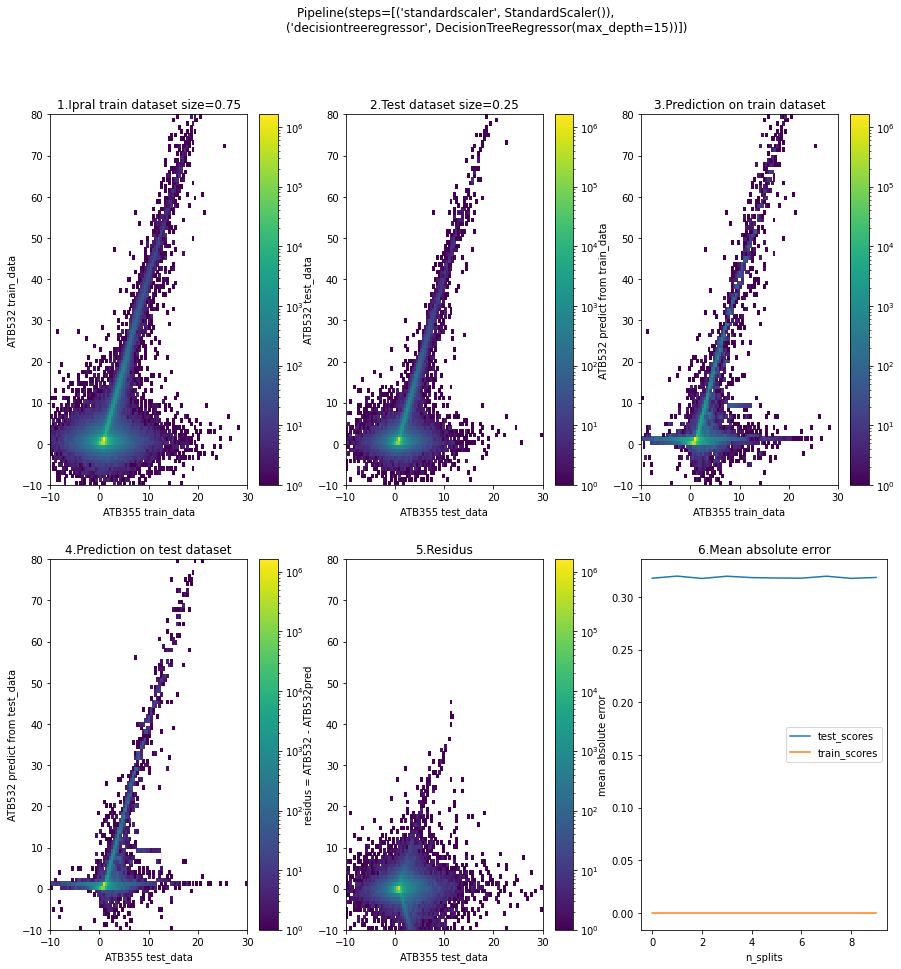

In [101]:

# training with preprocessing
#-------------------------------
modelp = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=15))
modelp.fit(data_train, target_train)

cv_results_p = cross_validate(modelp, data_train, target_train, cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True, n_jobs=2)

cv_results_p = pd.DataFrame(cv_results_p)
print(cv_results_p)


data_predicttest = modelp.predict(data_test)
data_predicttrain = modelp.predict(data_train)
params_plot = {
    'titles' : ['1.Ipral train dataset size=0.75', '2.Test dataset size=0.25', '3.Prediction on train dataset', 
                '4.Prediction on test dataset', '5.Residus', '6.Mean absolute error'],
    'bins' : 100,
    'norms' : LogNorm(),
    'ranges': [[-10,30], [-10,80]],
    'feature_position':0
}
scatterplot_predict_target(modelp, data_train, target_train, data_test, target_test,
                          data_predicttrain, data_predicttest, cv_results, params_plot)

In [128]:
# find best params with 3 features 

print(f'{model}')
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": np.arange(1, 10, 2)}
tree_reg = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid)
tree_reg.fit(data_train, target_train)


DecisionTreeRegressor()
GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([1, 3, 5, 7, 9])})


In [129]:
tree_reg.best_params_['max_depth']

9

(1759817, 3) (1759817,)
(1759817, 3) (1759817,)
(1759817, 3) (1759817,)
(1759818, 3) (1759818,)


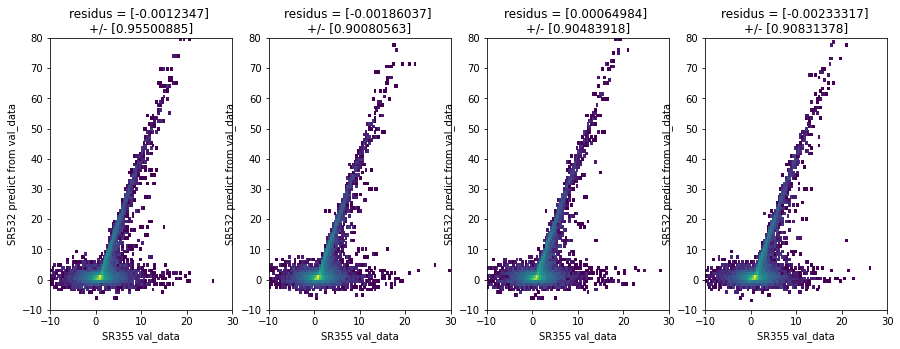

In [13]:
from sklearn.model_selection import KFold
n_splits = 4
kf = KFold(n_splits=n_splits)

Fig, axs = plt.subplots(ncols=n_splits, figsize=(15,5))
for (id_train, id_val), (i, ax) in zip(kf.split(allsr355_train), enumerate(axs.flat)):
    XFold_train, YFold_train = allsr355_train[id_train,:], allsr532_train[id_train]
    XFold_val, YFold_val = allsr355_train[id_val,:], allsr532_train[id_val]
    print(XFold_train.shape, YFold_train.shape)
    sr532_pred, stat_residus, treemodel3 = DecisionTree_model(XFold_train, YFold_train, XFold_val, YFold_val)
    #plot
    ax.hist2d(XFold_val[:,0], sr532_pred, bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm())
    ax.set(xlabel='SR355 val_data', ylabel='SR532 predict from val_data',
           title=f"residus = {stat_residus.loc['mean'].values} \n+/- {stat_residus.loc['std'].values}")

[Text(0.5, 0, 'SR355 val_data'),
 Text(0, 0.5, 'SR532 predict from val_data'),
 Text(0.5, 1.0, 'residus = [-0.00339836] \n+/- [0.88778123]')]

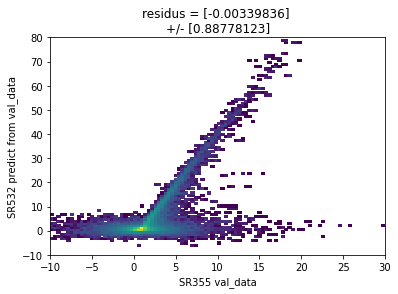

In [20]:

fullsr532_predict3, full_stast3, treemodel_full3 = DecisionTree_model(allsr355_train, allsr532_train, allsr355_test, allsr532_test)
fg, ax = plt.subplots()
ax.hist2d(allsr355_test[:,0], fullsr532_predict3, bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm())
ax.set(xlabel='SR355 val_data', ylabel='SR532 predict from val_data',
       title=f"residus = {full_stast3.loc['mean'].values} \n+/- {full_stast3.loc['std'].values}")

In [102]:
### SR532 to SR355 
from sklearn.model_selection import train_test_split

allsr355_after = allsr355.ravel()
allsr532_after = add_feature(allsr532.ravel(), mat_alt.ravel())

mask = remove_NaN_Inf_values(allsr355_after, allsr532_after[:,0])
allsr355_after = allsr355_after[mask]
allsr532_after = allsr532_after[mask,:]

allsr532_train, allsr532_test, allsr355_train, allsr355_test= train_test_split(allsr532_after, allsr355_after,  
                                                                                test_size=0.35, random_state=0)


shape of data after adding feature: (4472003, 2)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
          8. ,   8.4,   8.8,   9.2,   9.6,  10. ,  10.4,  10.8,  11.2,
         11.6,  12. ,  12.4,  12.8,  13.2,  13.6,  14. ,  14.4,  14.8,
         15.2,  15.6,  16. ,  16.4,  16.8,  17.2,  17.6,  18. ,  18.4,
         18.8,  19.2,  19.6,  20. ,  20.4,  20.8,  21.2,  21.6,  22. ,
         22.4,  22.8,  23.2,  23.6,  24. ,  24.4,  24.8,  25.2,  25.6,
         26. ,  26.4,  26.8,  27.2,  27.6

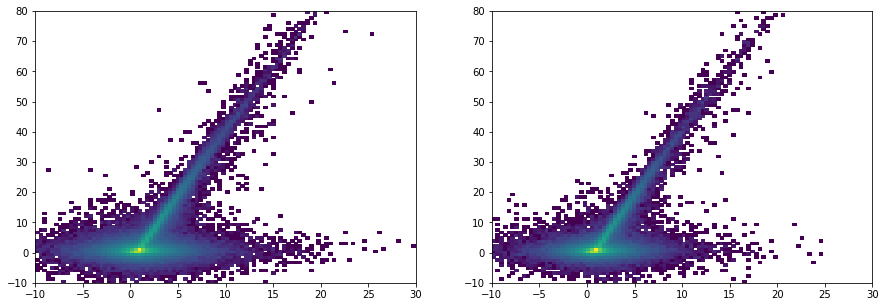

In [106]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax.hist2d(allsr355_train, allsr532_train[:,0], bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm())
ax2.hist2d(allsr355_test, allsr532_test[:,0], bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm())

(1759817, 2) (1759817,)
(1759817, 2) (1759817,)
(1759817, 2) (1759817,)
(1759818, 2) (1759818,)


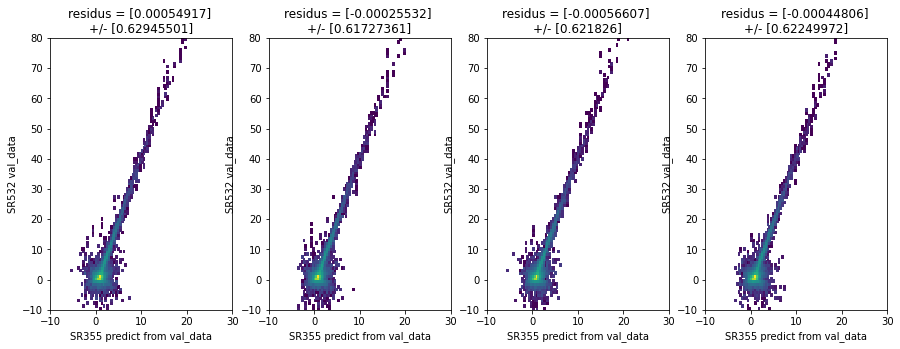

In [103]:
from sklearn.model_selection import KFold
n_splits = 4
kf = KFold(n_splits=n_splits)

Fig, axs = plt.subplots(ncols=n_splits, figsize=(15,5))
for (id_train, id_val), (i, ax) in zip(kf.split(allsr532_train), enumerate(axs.flat)):
    XFold_train, YFold_train = allsr532_train[id_train,:], allsr355_train[id_train]
    XFold_val, YFold_val = allsr532_train[id_val,:], allsr355_train[id_val]
    print(XFold_train.shape, YFold_train.shape)
    sr355_pred, stat_residus, treemodel = DecisionTree_model(XFold_train, YFold_train, XFold_val, YFold_val)
    #plot
    ax.hist2d(sr355_pred, XFold_val[:,0], bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm())
    ax.set(ylabel='SR532 val_data', xlabel='SR355 predict from val_data',
           title=f"residus = {stat_residus.loc['mean'].values} \n+/- {stat_residus.loc['std'].values}")

In [104]:
fullsr355_predict, full_stast, treemodel_full = DecisionTree_model(allsr532_train, allsr355_train, allsr532_test, allsr355_test)

[Text(0, 0.5, 'SR532 test_data'),
 Text(0.5, 0, 'SR355 predict from test_data'),
 Text(0.5, 1.0, 'residus = [0.00084559] \n+/- [0.61657219]')]

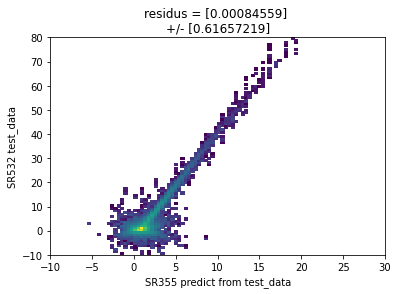

In [105]:
fg, ax = plt.subplots()
ax.hist2d(fullsr355_predict, allsr532_test[:,0], bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm())
ax.set(ylabel='SR532 test_data', xlabel='SR355 predict from test_data',
       title=f"residus = {full_stast.loc['mean'].values} \n+/- {full_stast.loc['std'].values}")

### EXEMPLE 1 QUICKLOOK IPRAL

<ipython-input-44-91b9848e8bbc>:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  cmap.set_under('lightgrey')
<ipython-input-44-91b9848e8bbc>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolormesh(dttime, dtalt, dtsr532.T, cmap='turbo', vmin=0, vmax=20)
<ipython-input-44-91b9848e8bbc>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass s

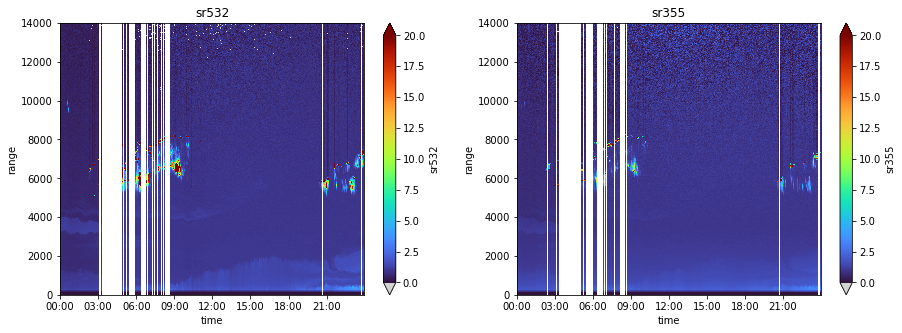

In [44]:
### essayer avec un cas d'étude en quicklook 
dt = xr.open_dataset('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20200904_000000_1440.nc')

dtsr355 = (dt['calibrated']/dt['simulated']).sel(wavelength=355).where(dt['flags'].sel(wavelength=355) == 0, drop=False).values 
dtsr532 = (dt['calibrated']/dt['simulated']).sel(wavelength=532).where(dt['flags'].sel(wavelength=532) == 0, drop=False).values
dtalt = dt['range'].values
dttime = dt['time'].values

negative_where = np.where(dtsr355 < 0)
dtsr355[negative_where] = np.nan

import matplotlib.dates as mdates
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,5))
cmap = plt.cm.turbo
cmap.set_under('lightgrey')
# 532nm original
p = ax.pcolormesh(dttime, dtalt, dtsr532.T, cmap='turbo', vmin=0, vmax=20)
plt.colorbar(p, ax=ax, label='sr532', extend='both')
ax.set_ylim(0,14000)
ax.set(xlabel='time', ylabel='range', title='sr532')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# 355nm original
p = ax2.pcolormesh(dttime, dtalt, dtsr355.T, cmap='turbo', vmin=0, vmax=20)
plt.colorbar(p, ax=ax2, label='sr355', extend='both')
ax2.set_ylim(0,14000)
ax2.set(xlabel='time', ylabel='range', title='sr355')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

In [47]:
### essayer avec un cas d'étude en quicklook (suite)
dtX2 = add_feature(dtsr355.ravel(), np.tile(dtalt, dtsr355.shape[0]))
dtalt_mat = np.tile(dtalt, (dtsr355.shape[0],1))
# 3e feature of X_mat
from tqdm import tqdm
X3 = np.zeros(dtalt_mat.shape)
print(X3.shape)
# X3[0,:] = np.nan
for j in tqdm(range(1, dtalt_mat.shape[1])):
    X3[:,j] = X3[:,j-1] + dtsr355[:,j]*(dtalt_mat[:,j] - dtalt_mat[:,j-1])

dtX = add_feature(dtX2, X3.ravel())


Updating shape: (11376000, 1), (11376000, 1)
shape of data after adding feature: (11376000, 2)


  8%|▊         | 333/3999 [00:00<00:01, 3323.49it/s]

(2844, 4000)


100%|██████████| 3999/3999 [00:01<00:00, 3797.72it/s]


Updating shape: (11376000, 2), (11376000, 1)
shape of data after adding feature: (11376000, 3)
Index : (array([       0,        0,        0, ..., 11375998, 11375999, 11375999]), array([0, 1, 2, ..., 1, 0, 1])) and (17824924,)


In [55]:
dtX[np.where(~np.isnan(dtX))[0],:]

array([[4.02673049e-07, 1.50000000e+01, 0.00000000e+00],
       [4.02673049e-07, 1.50000000e+01, 0.00000000e+00],
       [4.02673049e-07, 1.50000000e+01, 0.00000000e+00],
       ...,
       [1.73545107e+03, 5.99850000e+04,            nan],
       [1.98370089e+03, 6.00000000e+04,            nan],
       [1.98370089e+03, 6.00000000e+04,            nan]])

In [49]:
indx = np.where(np.logical_and(~np.isnan(dtX), ~np.isinf(dtX)))
print(f'Index : {indx} and {indx[0].shape}')
dtX_input = dtX[np.unique(indx[0]), :]


dtXpredict = model.predict(dtX_input)
tmp = np.full(dtsr532.shape[0], np.nan)
dtXpredict = dtXpredict.reshape(dtsr532.shape)

# fig, ax = plt.subplots()
# cmap = plt.cm.turbo
# cmap.set_under('lightgrey')

# p = ax.pcolormesh(dttime, dtalt, dtXpredict.T, cmap=cmap, vmin=0, vmax=20)
# plt.colorbar(p, ax=ax, label='sr532 predict', extend='both')
# ax.set_ylim(4000,14000)
# ax.set(xlabel='time', ylabel='range', title='sr532 predict')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


Index : (array([       0,        0,        0, ..., 11375998, 11375999, 11375999]), array([0, 1, 2, ..., 1, 0, 1])) and (17824924,)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [30]:
print(dtXpredict[negative_where], dtsr532)

[  0.93640312   0.52392568   1.19110923 ... 413.33790021 413.33790021
 413.33790021]


# Apply on ER2

------------------

In [7]:
allsr532 = xr.open_dataset('/homedata/nmpnguyen/ORACLES-ER2/RF/Calibrated/HSRL2_ER2_allsr532_v3.nc')
allsr532 = allsr532.assign_coords(time = pd.to_datetime(allsr532['time']))['__xarray_dataarray_variable__']
# allsr532 = allsr532.resample(time = '15min').mean(skipna=True)

In [8]:
allsr355 = xr.open_dataset('/homedata/nmpnguyen/ORACLES-ER2/RF/Calibrated/HSRL2_ER2_allsr355_v3.nc')
allsr355 = allsr355.assign_coords(time = pd.to_datetime(allsr355['time']))['__xarray_dataarray_variable__']
# allsr355 = allsr355.resample(time = '15min').mean(skipna=True)

In [9]:
mat_alt = np.tile(allsr355['altitude'].values, (allsr355.values.shape[0], 1))
mat_time = np.tile(allsr355['time'].values, (allsr355.values.shape[1], 1))

---------------

In [60]:
mat_alt.shape, allsr355.shape

((20894, 2069), (20894, 2069))

In [13]:
from sklearn.model_selection import train_test_split
# allsr355 = allsr355.values
# allsr532 = allsr532.values

allsr355_after = add_feature(allsr355.ravel(), mat_alt.ravel())
allsr532_after = allsr532.ravel()

mask = np.logical_and(~np.isnan(allsr355_after[:,0]), ~np.isnan(allsr532_after))
allsr355_after = allsr355_after[mask,:]
allsr532_after = allsr532_after[mask]

allsr355_train, allsr355_test, allsr532_train, allsr532_test = train_test_split(allsr355_after, allsr532_after, 
                                                                                test_size=0.35, random_state=0)
print(allsr355_train.shape, allsr532_test.shape)

Updating shape: (43229686, 1), (43229686, 1)
shape of data after adding feature: (43229686, 2)
(12667795, 2) (6821121,)


(8445196, 2) (8445196,)
(8445197, 2) (8445197,)
(8445197, 2) (8445197,)


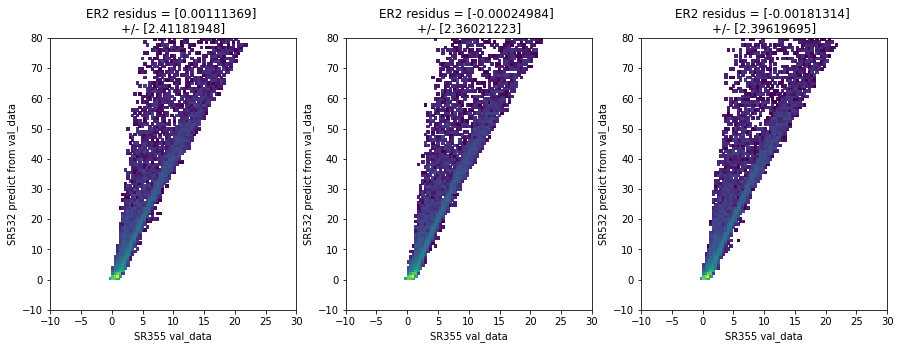

In [62]:
n_splits = 3
kf = KFold(n_splits=n_splits)

Fig, axs = plt.subplots(ncols=n_splits, figsize=(15,5))
for (id_train, id_val), (i, ax) in zip(kf.split(allsr355_train), enumerate(axs.flat)):
    XFold_train, YFold_train = allsr355_train[id_train,:], allsr532_train[id_train]
    XFold_val, YFold_val = allsr355_train[id_val,:], allsr532_train[id_val]
    print(XFold_train.shape, YFold_train.shape)
    sr532_pred, stat_residus, treemodel_for_er2 = DecisionTree_model(XFold_train, YFold_train, XFold_val, YFold_val)
    #plot
    ax.hist2d(XFold_val[:,0], sr532_pred, bins=100, range=[[-10,30], [-10, 80]], norm=LogNorm())
    ax.set(xlabel='SR355 val_data', ylabel='SR532 predict from val_data',
           title=f"ER2 residus = {stat_residus.loc['mean'].values} \n+/- {stat_residus.loc['std'].values}")

In [15]:
fullsr532_predict_er2, full_stast_er2, treemodel_full_er2 = DecisionTree_model(allsr355_train, allsr532_train, allsr355_test, allsr532_test)

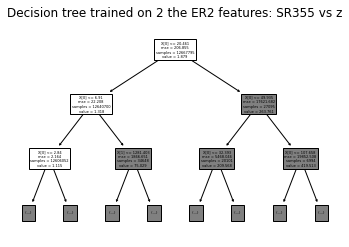

In [18]:
# clf = treemodel_full_er2.fit(allsr355_train, allsr532_train)
from sklearn import tree
plotree, ax = plt.subplots(figsize=(10,8))
treemodel_full_er2 = treemodel_full_er2.fit(allsr355_train, allsr532_train)
tree.plot_tree(treemodel_full_er2, max_depth=2, filled=False, ax=ax)
plt.title("Decision tree trained on 2 the ER2 features: SR355 vs z")
plt.savefig('/homedata/nmpnguyen/ORACLES-ER2/Figs/decision_tree_tmp.png')

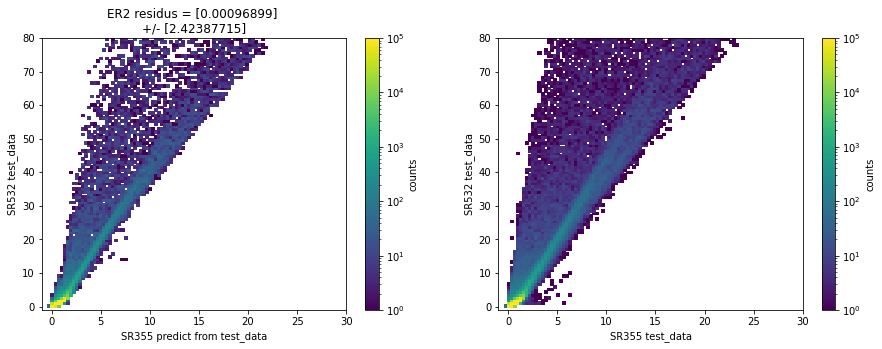

In [101]:
fg, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,5))
h = ax.hist2d(allsr355_test[:,0], fullsr532_predict_er2, bins=[100, 100], range=[[-1,30], [-1, 80]], norm=LogNorm(vmax=1e5))
ax.set(ylabel='SR532 test_data', xlabel='SR355 predict from test_data',
       title=f"ER2 residus = {full_stast_er2.loc['mean'].values} \n+/- {full_stast_er2.loc['std'].values}")
plt.colorbar(h[3], ax=ax, label='counts')

h2 = ax2.hist2d(allsr355_test[:,0], allsr532_test, bins=[100, 100], range=[[-1,30], [-1, 80]], norm=LogNorm(vmax=1e5))
ax2.set(ylabel='SR532 test_data', xlabel='SR355 test_data')
plt.colorbar(h2[3], ax=ax2, label='counts')

### EXEMPLE 1 PROFIL OU 1 QUICKLOOK DE ER2

Updating shape: (1950156, 1), (1950156, 1)
shape of data after adding feature: (1950156, 2)


<ipython-input-92-7fd02cf5593a>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolormesh(dt['time'].values, dtalt, dtsr532.T, cmap='turbo', vmin=0, vmax=10)


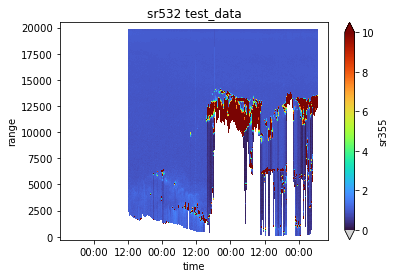

In [92]:
dt = xr.open_dataset('/homedata/nmpnguyen/ORACLES-ER2/RF/Calibrated/HSRL2_ER2_20160819_R8.h5')

dtsr355 = (dt['calibrated']/dt['molecular']).sel(wavelength=355).values
dtsr532 = (dt['calibrated']/dt['molecular']).sel(wavelength=532).values
dtalt = dt['altitude'].values

dtX = add_feature(dtsr355.ravel(), np.tile(dtalt, dtsr355.shape[0]))


import matplotlib.dates as mdates
fig, ax = plt.subplots()
p = ax.pcolormesh(dt['time'].values, dtalt, dtsr532.T, cmap='turbo', vmin=0, vmax=10)
plt.colorbar(p, ax=ax, label='sr355', extend='both')
ax.set(xlabel='time', ylabel='range', title='sr532 test_data')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

<ipython-input-90-ef7532d5fb1d>:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  cmap.set_under('lightgrey')
<ipython-input-90-ef7532d5fb1d>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolormesh(dt['time'].values, dtalt, dtYpred_er2.T, cmap=cmap, vmin=0.2, vmax=10)


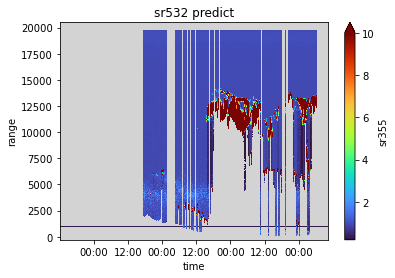

In [90]:
# dtX = dtX[~np.isnan(dtX[:,0]),:]
dtYpred_er2= treemodel_full_er2.predict(np.nan_to_num(dtX))
dtYpred_er2 = dtYpred_er2.reshape(dtsr355.shape)

fig, ax = plt.subplots()
cmap = plt.cm.turbo 
cmap.set_under('lightgrey')
p = ax.pcolormesh(dt['time'].values, dtalt, dtYpred_er2.T, cmap=cmap, vmin=0.2, vmax=10)
plt.colorbar(p, ax=ax, label='sr355', extend='max')
ax.set(xlabel='time', ylabel='range', title='sr532 predict')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

### Build data train > Decision Tree Model
---------------------------------------------------------

In [157]:
# get profil from day file
# get get data from profil 
# get all moments 

def get_profil_random_from_dayfile(daytime, nb_profils):
    daytime = pd.to_datetime(daytime)
    import random 
    ns = random.sample(range(len(daytime)), min(nb_profils, len(daytime)))   
    return ns

def get_data_from_profil(dayfile, z_limite, nb_profils):
    z = dayfile['range'].values
    z_selected = z[z < z_limite] if isinstance(z_limite,int) else z[(z > z_limite[0])&(z < z_limite[1])]
    x355 = dayfile['Total_ScattRatio_355'].where(dayfile['flags_355']==0, drop=False).sel(range=z_selected)#
    x532 = dayfile['Total_ScattRatio_532'].where(dayfile['flags_532']==0, drop=False).sel(range=z_selected)#.isel(time=profils_selected).values
    x355 = x355.resample(time = '15min').mean(skipna=True)
    x532 = x532.resample(time = '15min').mean(skipna=True)
    times = np.intersect1d(x355.time, x532.time)
    # get_profil_random_from_dayfile 
    profils_selected = get_profil_random_from_dayfile(times, nb_profils)
    x355 = x355.isel(time=profils_selected).values
    x532 = x532.isel(time=profils_selected).values
    # remove nan values
    mask_nan = ~np.isnan(x355)&~np.isnan(x532)
    x355 = x355[mask_nan]
    x532 = x532[mask_nan]
    z2D_selected = np.tile(z_selected, (len(profils_selected), 1))[mask_nan]
    return x355, z2D_selected, x532

def get_all_data_selected_2features(alldaysfile, nb_profils, z_limite):
    all_X355 = np.array([[],[]])
    all_X532 = np.array([])
    for day in alldaysfile:
        day_data = xr.open_dataset(day)
#         profils_id = get_profil_random_from_dayfile(day_data, nb_profils)
        X355, Zselected, X532 = get_data_from_profil(day_data, z_limite, nb_profils)
        all_X355 = np.concatenate([all_X355, [X355, Zselected]], axis=1)
        all_X532 = np.concatenate([all_X532, X532])
    return np.array(all_X355).T, np.array(all_X532)




In [432]:
Listfiles = sorted(Path('/homedata/nmpnguyen/IPRAL/NETCDF/v2/').glob('ipral_calib_03_2018*.nc'))
X355_Z, X532= get_all_data_selected_2features(Listfiles, 100, 14000)
# X355_Z, X532= get_all_data_selected_3features(Listfiles[:100], 100, 14000)

In [433]:
X355_Z.shape, X532.shape

((3657360, 2), (3657360,))

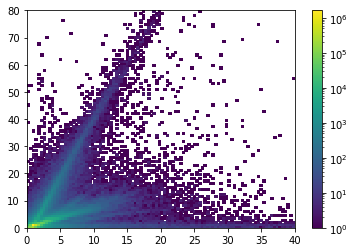

In [434]:
%matplotlib inline
fig, ax = plt.subplots()
h = ax.hist2d(X355_Z[:,0],  X532, bins=100, range=[[0, 40],[0, 80]], norm=LogNorm())
plt.colorbar(h[3], ax=ax)

In [403]:
Y = X532[np.logical_and(X355_Z[:,0]>0,X532>0)]# training
X = X355_Z[np.logical_and(X355_Z[:,0]>0,X532>0),:]# training
# Y = Y/X[:,0]# training

# Y=Y[np.logical_and(X[:,1]<14000,X[:,1]>3000)] # training
# X = X[np.logical_and(X[:,1]<14000,X[:,1]>3000)] # training

# Y=Y[X[:,0]>1.2]
# X = X[X[:,0]>1.2,:]

X.shape


(1168250, 2)

(array([183214., 883734.,  53316.,  20268.,   7173.,   4026.,   2097.,
          1459.,   1107.,    985.]),
 array([8.09097605e-09, 7.99989950e-01, 1.59997989e+00, 2.39996983e+00,
        3.19995978e+00, 3.99994972e+00, 4.79993966e+00, 5.59992960e+00,
        6.39991955e+00, 7.19990949e+00, 7.99989943e+00]),
 <BarContainer object of 10 artists>)

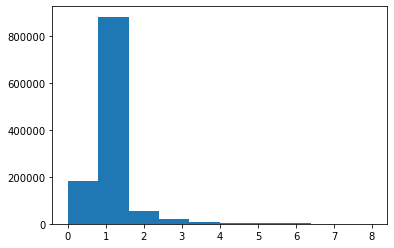

In [404]:
fig, ax = plt.subplots()
ax.hist(Y[Y<8], bins=10)

In [405]:
from sklearn.tree import DecisionTreeRegressor as DTR
tree = DTR(min_samples_leaf=5)
tree.fit(X,Y)

DecisionTreeRegressor(min_samples_leaf=5)

In [408]:
file_test = Path('/homedata/nmpnguyen/IPRAL/NETCDF/v2/ipral_calib_03_20181017_000000_1440.nc')
Xtest, Ytest = get_all_data_selected_2features([file_test], 1, 14000)
# Xtest, Ytest = get_all_data_selected_3features([file_test], 100, 14000)

In [409]:
Yt = Ytest[np.logical_and(Xtest[:,0]>0,Ytest>0)]
Xt = Xtest[np.logical_and(Xtest[:,0]>0,Ytest>0),:]
# Yt = Yt/Xt[:,0]

# Yt=Yt[np.logical_and(Xt[:,1]<14000,Xt[:,1]>3000)]
# Xt = Xt[np.logical_and(Xt[:,1]<14000,Xt[:,1]>3000)]

# Yt = Yt[Xt[:,0] >1.2]
# Xt = Xt[Xt[:,0]>1.2, :]


Xt.shape
Y_pred = tree.predict(Xt)

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

(0.0, 4000.0)

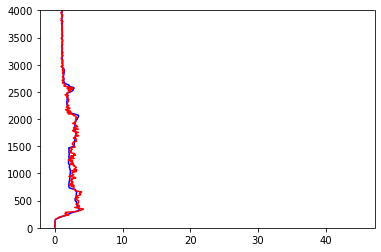

In [377]:
fig, ax = plt.subplots()

Yo = Ytest[np.logical_and(Xtest[:,0]>0,Ytest>0)]
Xo = Xtest[np.logical_and(Xtest[:,0]>0,Ytest>0),:]


# ax.plot(Ytest[np.logical_and(Xtest[:,0]>0,Ytest>0)], Xt[:,1], color='b')
ax.plot(Yo, Xo[:,1], color='b')
ax.plot(Y_pred, Xt[:,1], color='r')
# ax.plot(Xt[:,0], Xt[:,1], color='g')
ax.set_ylim(0, 4000)

In [410]:
# list of test days
list_files_test = sorted(Path('/homedata/nmpnguyen/IPRAL/NETCDF/v2/').glob('ipral_calib_03_20180*.nc'))
Xtest, Ytest = get_all_data_selected_2features(list_files_test, 100, 14000)
Yt = Ytest[np.logical_and(Xtest[:,0]>0,Ytest>0)]
Xt = Xtest[np.logical_and(Xtest[:,0]>0,Ytest>0),:]


[Text(0.5, 0, 'sr355_mesured'), Text(0, 0.5, 'sr532_mesured')]

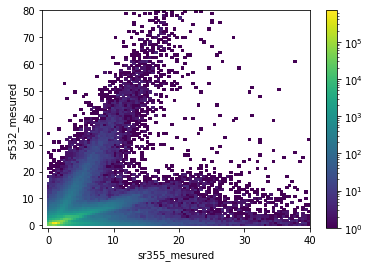

In [411]:
# scatterplot before applying model
fig, ax = plt.subplots()
h = ax.hist2d(Xt[:,0],  Yt, bins=100, range=[[-1, 40],[-1, 80]], norm=LogNorm())
plt.colorbar(h[3], ax=ax)
ax.set(xlabel='sr355_mesured', ylabel='sr532_mesured')

In [245]:
alsr355 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['__xarray_dataarray_variable__'].values
alsr532 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr532-3000-4000.nc')['__xarray_dataarray_variable__'].values

# fig, ax = plt.subplots()
# pcm = ax.hist2d(alsr355.ravel(), alsr532.ravel(), bins=100, range=[[-10,40], [-10,80]], norm=LogNorm(vmin=1, vmax=1e5))
# plt.colorbar(pcm[3], ax=ax)

In [171]:
t = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['time']
list_random50 = get_profil_random_from_dayfile(t, np.int(alsr532.shape[0]/2))
list_notrandom50 = list(set(range(alsr532.shape[0])) - set(list_random50))

print(type(list_notrandom50))

<class 'list'>


In [161]:
X = alsr355[list_random50, :]
Y = alsr532[list_random50, :]
mat_alt = np.tile(xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['range'].values, (X.shape[0], 1))
print(mat_alt.ravel().shape)
print(X.shape)
X = np.vstack((X.ravel(), mat_alt.ravel()))
X = X.T
Y = Y.ravel()
print(X.shape)



(2235602,)
(2798, 799)
(2235602, 2)


In [162]:
Yinput = Y[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(Y))]
Xinput = X[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(Y)),:]

# generate Decision Tree model
from sklearn.tree import DecisionTreeRegressor as DTR
tree = DTR(min_samples_leaf=5)
tree.fit(Xinput,Yinput)

DecisionTreeRegressor(min_samples_leaf=5)

In [114]:
# print(X[:,0], Y)
# fig, ax = plt.subplots()
# pcm = ax.hist2d(Xinput[:,0], Yinput, bins=100, range=[[-10,40], [-10,80]], norm=LogNorm(vmin=1, vmax=1e5))
# plt.colorbar(pcm[3], ax=ax)
# ax.set(xlabel='SR355_mesured', ylabel='SR532_mesured')
# fig.savefig(f'/home/nmpnguyen/scatter_train_data_{len(Xinput[:,0])}.png')

In [163]:
# generate Linear Regression
slope, intercept = [4.11964, -1.7804]

# generate Polynomial Regresssion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=2)
X_features = poly_features.fit_transform(Xinput)
reg = LinearRegression()
reg.fit(X_features, Yinput)

LinearRegression()

In [246]:
# generate Data Test 

X = alsr355[list_notrandom50, :]
Y = alsr532[list_notrandom50, :]
mat_alt = np.tile(xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['range'].values, (X.shape[0], 1))
X = np.vstack((X.ravel(), mat_alt.ravel()))
X = X.T
Y = Y.ravel()
Xtests = X[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(Y)),:]
Ytests = Y[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(Y))]


In [247]:
# create y predict from DCT
Y_pred = tree.predict(Xtests)
print(Xtests.shape, Y_pred.shape, Ytests.shape)
residus_y = Ytests - Y_pred
stat_DCT = pd.DataFrame(residus_y).describe()
print(stat_DCT)

(1800147, 2) (1800147,) (1800147,)
                  0
count  1.800147e+06
mean   5.711278e-03
std    9.378590e-01
min   -1.271080e+02
25%   -6.083773e-02
50%   -7.667266e-04
75%    5.247940e-02
max    4.569133e+01


In [248]:
# create y predict from Linear Regression
Y_pred2 = slope*Xtests[:,0] + intercept
print(Xtests.shape, Y_pred.shape, Ytests.shape)
residus2_y = Ytests - Y_pred2
stat_LR = pd.DataFrame(residus2_y).describe()
print(stat_LR)

(1800147, 2) (1800147,) (1800147,)
                  0
count  1.800147e+06
mean  -1.300328e+00
std    2.270221e+00
min   -1.346354e+02
25%   -1.594816e+00
50%   -1.389442e+00
75%   -1.048685e+00
max    1.088887e+02


In [249]:
# create y predict from Polynomial Regression
Xtests_features = poly_features.fit_transform(Xtests)

Y_pred3 = reg.predict(Xtests_features)
# print(Xtests.shape, Y_pred.shape, Ytests.shape)
residus3_y = Ytests - Y_pred3
stat_PR = pd.DataFrame(residus3_y).describe()
print(stat_PR)

                  0
count  1.800147e+06
mean   9.963508e-03
std    1.239664e+00
min   -6.128475e+01
25%   -2.496987e-01
50%   -6.906157e-02
75%    1.515945e-01
max    4.914315e+01


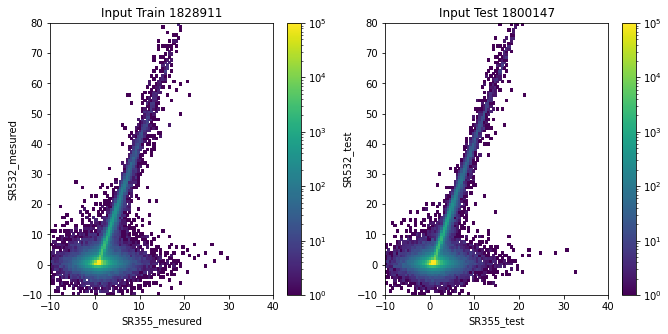

In [175]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(11,5))
pcm = ax.hist2d(Xinput[:,0], Yinput, bins=100, range=[[-10,40], [-10,80]], norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(pcm[3], ax=ax)
ax.set(xlabel='SR355_mesured', ylabel='SR532_mesured', title=f'Input Train {len(Xinput[:,0])}')

pcm = ax2.hist2d(Xtests[:,0], Ytests, bins=100, range=[[-10,40], [-10,80]], norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(pcm[3], ax=ax2)
ax2.set(xlabel='SR355_test', ylabel='SR532_test', title=f'Input Test {len(Xtests[:,0])}')
fig.savefig(f'/home/nmpnguyen/scatter_test_data_{len(Xtests[:,0])}_trainby{len(Xinput[:,0])}.png')

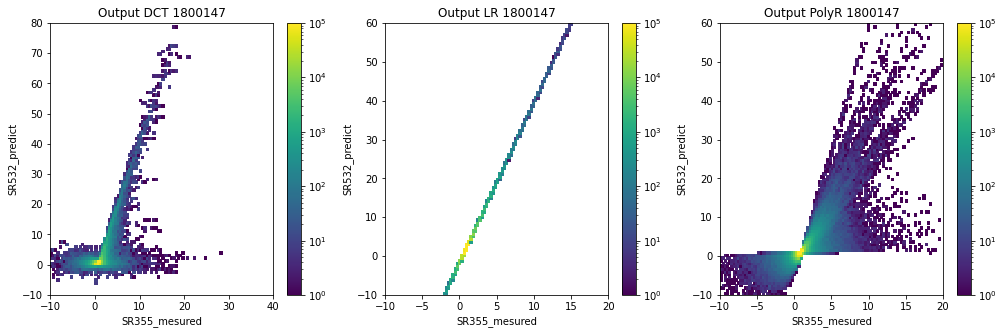

In [251]:
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(17,5)) #from DCTree
pcm = ax.hist2d(Xtests[:,0], Y_pred, bins=100, range=[[-10,40], [-10,80]], norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(pcm[3], ax=ax)
ax.set(xlabel='SR355_mesured', ylabel='SR532_predict', title=f'Output DCT {len(Xtests[:,0])}')
# fig.savefig(f'/home/nmpnguyen/scatter_predictDTC_data_{len(Xtests[:,0])}.png')

pcm = ax2.hist2d(Xtests[:,0], Y_pred2, bins=100, range=[[-10,20], [-10,60]], norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(pcm[3], ax=ax2)
ax2.set(xlabel='SR355_mesured', ylabel='SR532_predict', title=f'Output LR {len(Xtests[:,0])}')

pcm = ax3.hist2d(Xtests[:,0], Y_pred3, bins=100, range=[[-10,20], [-10,60]], norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(pcm[3], ax=ax3)
ax3.set(xlabel='SR355_mesured', ylabel='SR532_predict', title=f'Output PolyR {len(Xtests[:,0])}')

fig.savefig(f'/home/nmpnguyen/scatter_predict_data_{len(Xtests[:,0])}_trainby{len(Xinput[:,0])}.png')

<IPython.core.display.Javascript object>


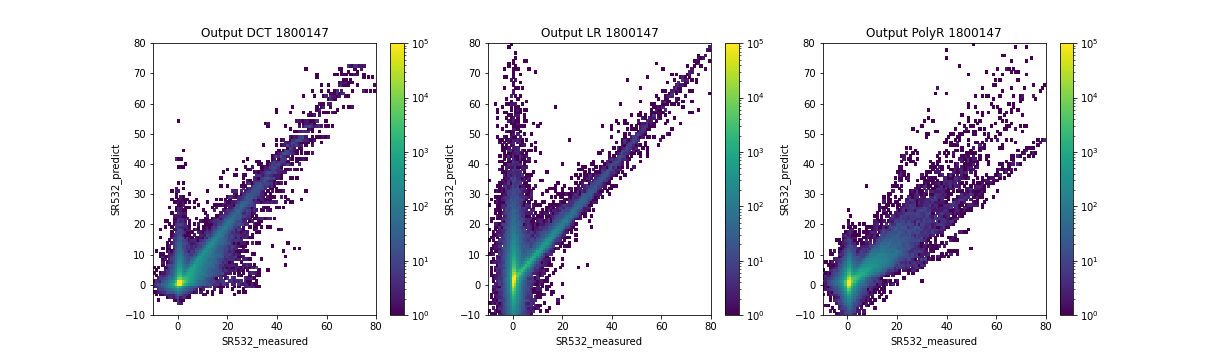

In [333]:
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(17,5)) #from DCTree
pcm = ax.hist2d(Ytests, Y_pred, bins=100, range=[[-10,80], [-10,80]], norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(pcm[3], ax=ax)
ax.set(ylabel='SR532_predict', xlabel='SR532_measured', title=f'Output DCT {len(Xtests[:,0])}')
# fig.savefig(f'/home/nmpnguyen/scatter_predictDTC_data_{len(Xtests[:,0])}.png')

pcm = ax2.hist2d(Ytests, Y_pred2, bins=100, range=[[-10,80], [-10,80]], norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(pcm[3], ax=ax2)
ax2.set(ylabel='SR532_predict', xlabel='SR532_measured', title=f'Output LR {len(Xtests[:,0])}')

pcm = ax3.hist2d(Ytests, Y_pred3, bins=100, range=[[-10,80], [-10,80]], norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(pcm[3], ax=ax3)
ax3.set(ylabel='SR532_predict', xlabel='SR532_measured', title=f'Output PolyR {len(Xtests[:,0])}')

fig.savefig(f'/home/nmpnguyen/scatter_532predict_532measured_{len(Xtests[:,0])}_trainby{len(Xinput[:,0])}.png')

In [112]:
# fig, ax = plt.subplots() #from Linear Regression
# pcm = ax.hist2d(Xtests[:,0], Y_pred2, bins=100, range=[[-10,20], [-10,60]], norm=LogNorm(vmin=1, vmax=1e5))
# plt.colorbar(pcm[3], ax=ax)
# ax.set(xlabel='SR355_mesured', ylabel='SR532_predict')
# fig.savefig(f'/home/nmpnguyen/scatter_predictLR_data_{len(Xtests[:,0])}.png')

In [113]:
# fig, ax = plt.subplots() #from Linear Regression
# pcm = ax.hist2d(Xtests[:,0], Y_pred3, bins=100, range=[[-10,20], [-10,60]], norm=LogNorm(vmin=1, vmax=1e5))
# plt.colorbar(pcm[3], ax=ax)
# ax.set(xlabel='SR355_mesured', ylabel='SR532_predict')
# fig.savefig(f'/home/nmpnguyen/scatter_predictPolyR_data_{len(Xtests[:,0])}.png')

(799,) (799,) (799,)
(733, 2) (733,)


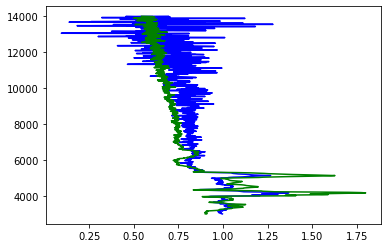

In [184]:
import random

# generate Data Test 1 Profile

# d = xr.open_dataset('/homedata/nmpnguyen/IPRAL/RF/Calibrated/zone-3000-4000/ipral_1a_Lz1R15mF30sPbck_v01_20181106_000000_1440.nc')
# X = (d['calibrated']/d['simulated']).sel(wavelength=355).resample(time='15min').mean(skipna=True)
# Y = (d['calibrated']/d['simulated']).sel(wavelength=532).resample(time='15min').mean(skipna=True)
# mat_alt = d['range'].values

mat_alt = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['range'].values
# i = random.randint(0, alsr355.shape[0])
i = random.choice(list_random50)

X = alsr355[i,:]
Y = alsr532[i,:]
# X = X.values[i,:]
# Y = Y.values[i,:]
%matplotlib inline
f, ax = plt.subplots()
ax.plot(X[mat_alt<14000], mat_alt[mat_alt<14000], color='b')
ax.plot(Y[mat_alt<14000], mat_alt[mat_alt<14000], color='g')
# ax.set_xlim(-1,10)

print(X.shape, Y.shape, mat_alt.shape)
X = np.vstack((X[mat_alt<14000], mat_alt[mat_alt<14000]))
X = X.T
Y = Y[mat_alt<14000]
Xtests = X[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(Y))]
Ytests = Y[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(Y))]
print(Xtests.shape, Ytests.shape)

# create y predict
Y_pred = tree.predict(Xtests)
Y_pred2 = slope*Xtests[:,0] + intercept
Xtests_features = poly_features.fit_transform(Xtests)
Y_pred3 = reg.predict(Xtests_features)



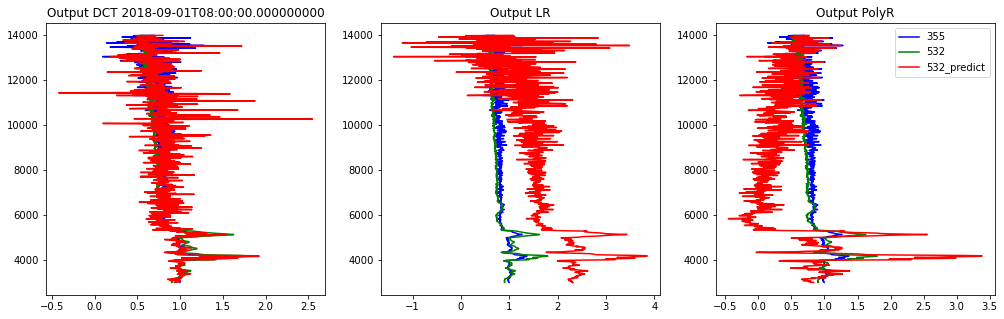

In [185]:
%matplotlib inline
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(17,5))
title=xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['time'].values[i]

ax.plot(X[:,0], X[:,1], color='b')
ax.plot(Y, X[:,1], color='g')
ax.plot(Y_pred, Xtests[:,1], color='r')
ax.set(title=f'Output DCT {title}')
# fig.savefig(f'/home/nmpnguyen/profile_predictDCT_trainby{len(Xinput[:,0])}_{title}.png')


ax2.plot(X[:,0], X[:,1], color='b')
ax2.plot(Y, X[:,1], color='g')
ax2.plot(Y_pred2, Xtests[:,1], color='r')
ax2.set(title=f'Output LR')
# fig.savefig(f'/home/nmpnguyen/profile_predictLR_trainby{len(Xinput[:,0])}_{title}.png')

ax3.plot(X[:,0], X[:,1], color='b', label='355')
ax3.plot(Y, X[:,1], color='g', label='532')
ax3.plot(Y_pred3, Xtests[:,1], color='r', label='532_predict')
ax3.set(title=f'Output PolyR')
ax3.legend()
fig.savefig(f'/home/nmpnguyen/profile_predict_trainby{len(Xinput[:,0])}_{title}.png')

In [186]:
# fig, ax = plt.subplots()
# ax.plot(X[:,0], X[:,1], color='b')
# ax.plot(Y, X[:,1], color='g')
# # ax.set_ylim(0,14000)
# ax.plot(Y_pred3, Xtests[:,1], color='r')
# # ax.set_xlim(-1,10)
# ax.set(title=f'{title}')
# fig.savefig(f'/home/nmpnguyen/profile_predictPolyR_trainby{len(Xinput[:,0])}_{title}.png')

(64, 799) (64, 799)
(51136, 2) (51136,)


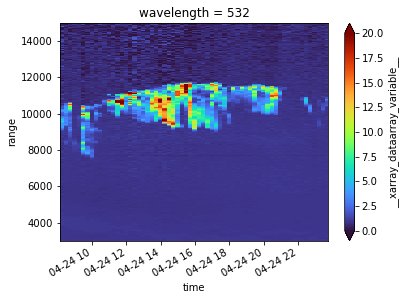

In [351]:
# Generate Data Test 1 Jour
# random.choice(np.unique(pd.to_datetime(t).strftime('%Y%m%d')))
alsr355 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['__xarray_dataarray_variable__']
alsr532 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr532-3000-4000.nc')['__xarray_dataarray_variable__']
mat_alt = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['range'].values

# ii = np.where(pd.to_datetime(t).strftime('%Y%m%d') == random.choice(np.unique(pd.to_datetime(t).strftime('%Y%m%d'))))[0]

X = alsr355[ii,:]
Y = alsr532[ii,:]

print(X.shape, Y.shape)

%matplotlib inline
fig, ax = plt.subplots()
Y.plot(x='time', y='range', cmap='turbo', vmax=20, vmin=0)

X = np.vstack((X.values.ravel(), np.tile(mat_alt, (X.shape[0],1)).ravel()))
X = X.T
Y = Y.values.ravel()
Xtests = X#[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(Y))]
Ytests = Y#[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(Y))]
print(Xtests.shape, Ytests.shape)

# create y predict
Y_pred = tree.predict(Xtests)
Y_pred2 = slope*Xtests[:,0] + intercept
Xtests_features = poly_features.fit_transform(Xtests)
Y_pred3 = reg.predict(Xtests_features)

<ipython-input-360-5fa9655bff0a>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(t.values[ii], mat_alt, Y_pred.reshape(alsr355[ii,:].shape).T,


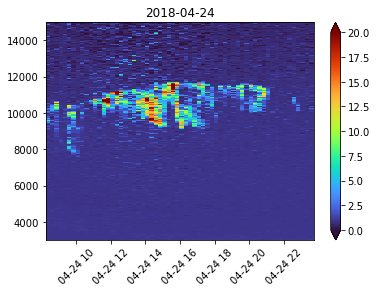

In [360]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(t.values[ii], mat_alt, Y_pred.reshape(alsr355[ii,:].shape).T, 
              cmap='turbo',vmax=20, vmin=0)
plt.colorbar(pcm, ax=ax, extend='both')
plt.xticks(rotation = 45)
title = pd.to_datetime(t.values[ii][0]).strftime('%Y-%m-%d')
ax.set(title = title)
fig.savefig(f'/home/nmpnguyen/ql_predict_trainby{len(Xinput[:,0])}_{title}.png')


--------------------------------

### Vérification les comportements différents entre 2 sub-datasets (par un dataset coupé en deux)

---------------------------------------

In [320]:
alsr355 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['__xarray_dataarray_variable__']
alsr532 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr532-3000-4000.nc')['__xarray_dataarray_variable__']

# Fev2018 to Sep2018
X1 = alsr355[:np.int(alsr355.shape[0]/2),:]#.values
Y1 = alsr532[:np.int(alsr532.shape[0]/2),:]#.values
print(X1.shape)
# Sep2018 to Dec2018
X2 = alsr355[np.int(alsr355.shape[0]/2):,:]#.values 
Y2 = alsr532[np.int(alsr532.shape[0]/2):,:]#.values
print(X2)

(2798, 799)
<xarray.DataArray '__xarray_dataarray_variable__' (time: 2799, range: 799)>
[2236401 values with dtype=float64]
Coordinates:
  * time        (time) datetime64[ns] 2018-09-08T10:15:00 ... 2018-12-14T13:0...
  * range       (range) float32 3.015e+03 3.03e+03 ... 1.497e+04 1.498e+04
    wavelength  int64 ...


<IPython.core.display.Javascript object>


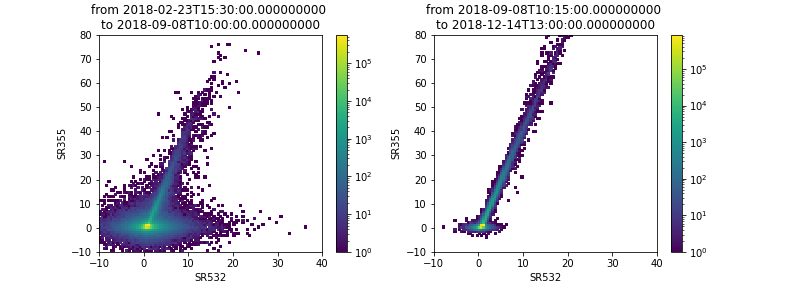

[Text(0.5, 1.0, 'from 2018-09-08T10:15:00.000000000 \nto 2018-12-14T13:00:00.000000000'),
 Text(0.5, 0, 'SR532'),
 Text(0, 0.5, 'SR355')]

In [317]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(11,4))
h1 = ax.hist2d(X1.values.ravel(), Y1.values.ravel(), bins=100, range=[[-10,40], [-10,80]], norm=LogNorm())
plt.colorbar(h1[3], ax=ax)
ax.set(title=f'from {X1.time.values[0]} \nto {X1.time.values[-1]}',
      xlabel='SR532', ylabel='SR355')
h2 = ax2.hist2d(X2.values.ravel(), Y2.values.ravel(), bins=100, range=[[-10,40], [-10,80]], norm=LogNorm())
plt.colorbar(h2[3], ax=ax2)
ax2.set(title=f'from {X2.time.values[0]} \nto {X2.time.values[-1]}',
       xlabel='SR532', ylabel='SR355')

<IPython.core.display.Javascript object>


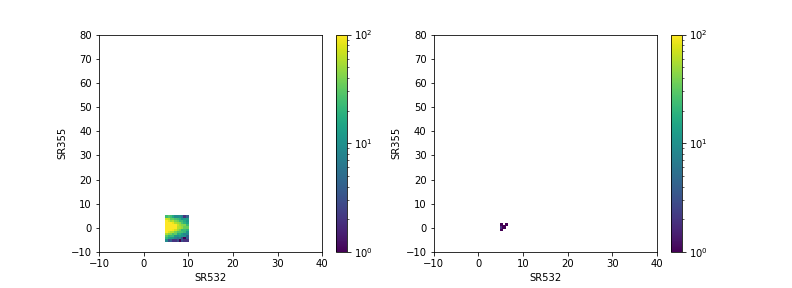

[Text(0.5, 0, 'SR532'), Text(0, 0.5, 'SR355')]

In [321]:
X1, Y1 = X1.values, Y1.values
X2, Y2 = X2.values, Y2.values
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(11,4))
xplot = X1[(X1>5) & (X1<10) & (Y1>-5) & (Y1<5)]
yplot = Y1[(X1>5) & (X1<10) & (Y1>-5) & (Y1<5)]
hh = ax.hist2d(xplot, yplot, bins=100, range=[[-10,40], [-10,80]], norm=LogNorm(vmax=1e2))
plt.colorbar(hh[3], ax=ax)
ax.set(xlabel='SR532', ylabel='SR355')

xplot = X2[(X2>5) & (X2<10) & (Y2>-5) & (Y2<5)]
yplot = Y2[(X2>5) & (X2<10) & (Y2>-5) & (Y2<5)]
hh = ax2.hist2d(xplot, yplot, bins=100, range=[[-10,40], [-10,80]], norm=LogNorm(vmax=1e2))
plt.colorbar(hh[3], ax=ax2)
ax2.set(xlabel='SR532', ylabel='SR355')

In [244]:
points1 = X1.where((X1>5) & (X1<10) & (Y1>-5) & (Y1<5), drop=False)
points2 = X2.where((X2>5) & (X2<10) & (Y2>-5) & (Y2<5), drop=False)
print(np.count_nonzero(~np.isnan(points1.values), axis=1).shape, points2)

(2798,) <xarray.DataArray '__xarray_dataarray_variable__' (time: 2799, range: 799)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2018-09-08T10:15:00 ... 2018-12-14T13:00:00
  * range    (range) float32 3.015e+03 3.03e+03 ... 1.497e+04 1.498e+04


In [204]:
X2[(X2>10) & (X2<15) & (Y2>-5) & (Y2<5)].shape, Y1[(X1>10) & (X1<15) & (Y1>-5) & (Y1<5)].shape

((0,), (592,))

In [308]:
points = alsr355.where((alsr355>5) & (alsr355<10) & (alsr532>-5) & (alsr532<5), drop=False)
# points1.resample(time='M').count().sum(axis=1)['time'], points2.resample(time='M').count().sum(axis=1)['time']
print(points.resample(time='M').count().sum(axis=1)['time'], alsr355.resample(time='M').count().sum(axis=1)['time'])
ratio_points = points.resample(time='M').count().sum(axis=1)/alsr355.resample(time='M').count().sum(axis=1)

<xarray.DataArray 'time' (time: 11)>
array(['2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
       '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-02-28 2018-03-31 ... 2018-12-31 <xarray.DataArray 'time' (time: 11)>
array(['2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
       '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000'], dtype

<xarray.DataArray '__xarray_dataarray_variable__' (time: 11)>
array([1.58928820e-04, 1.16891397e-03, 2.02478229e-03, 4.62064067e-03,
       7.58458803e-03, 4.08315825e-03, 1.06614750e-03, 1.27710659e-05,
       3.50578279e-06, 7.36214386e-06, 1.45530751e-05])
Coordinates:
  * time        (time) datetime64[ns] 2018-02-28 2018-03-31 ... 2018-12-31
    wavelength  int64 ...


<IPython.core.display.Javascript object>


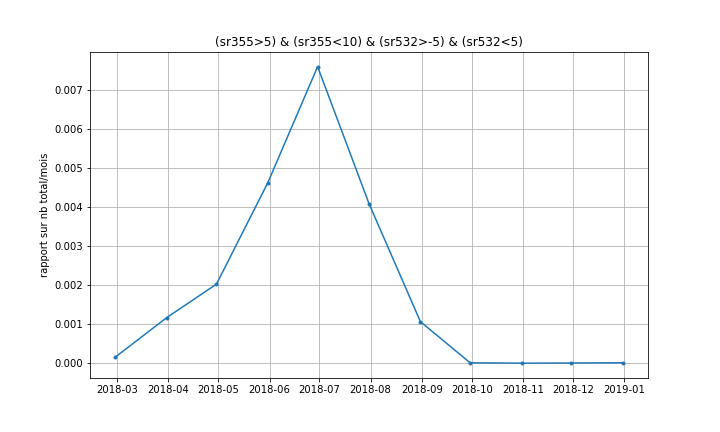

In [322]:
print(ratio_points)
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(t, bins='auto')
ax.plot(ratio_points['time'].values, ratio_points.values, marker='.')
ax.set(title='(sr355>5) & (sr355<10) & (sr532>-5) & (sr532<5)',
      ylabel='rapport sur nb total/mois')
plt.grid(True)


--------------------------------------
### Test de Decision tree avec 3 features 
------------------------------

In [ ]:
def get_all_data_selected_3features_v2(alldaysfile, nb_profils, z_limite):
    all_X355 = np.array([[], [], []])
    all_X532 = np.array([])

        day_data = xr.open_dataset(day)
#         profils_id = get_profil_random_from_dayfile(day_data, nb_profils)
        X355, Zselected, X532 = get_data_from_profil(day_data, z_limite, nb_profils)
        all_X355 = np.concatenate([all_X355, [X355, Zselected, np.square(Zselected)]], axis=1)
        all_X532 = np.concatenate([all_X532, X532])

In [397]:
alsr355 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['__xarray_dataarray_variable__'].values
alsr532 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr532-3000-4000.nc')['__xarray_dataarray_variable__'].values
t = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['time'].values

list_random50 = get_profil_random_from_dayfile(t, np.int(alsr532.shape[0]/2))
list_notrandom50 = list(set(range(alsr532.shape[0])) - set(list_random50))

In [401]:
X = alsr355[list_random50, :]
Y = alsr532[list_random50, :]
mat_alt = np.tile(xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['range'].values, (X.shape[0], 1))
print(mat_alt.shape)
print(X.shape)
print(mat_alt)


(2798, 799)
(2798, 799)
[[ 3015.  3030.  3045. ... 14955. 14970. 14985.]
 [ 3015.  3030.  3045. ... 14955. 14970. 14985.]
 [ 3015.  3030.  3045. ... 14955. 14970. 14985.]
 ...
 [ 3015.  3030.  3045. ... 14955. 14970. 14985.]
 [ 3015.  3030.  3045. ... 14955. 14970. 14985.]
 [ 3015.  3030.  3045. ... 14955. 14970. 14985.]]


In [392]:
from tqdm import tqdm
X3 = np.zeros(mat_alt.shape)
print(X3.shape)
X3[0,:] = np.nan
for j in tqdm(range(1, mat_alt.shape[1])):
    X3[:,j] = (X[:,j-1] + X[:,j]*(mat_alt[:,j] - mat_alt[:,j-1])).values
print(X3)

  0%|          | 0/798 [00:00<?, ?it/s]

(2798, 799)


100%|██████████| 798/798 [06:52<00:00,  1.94it/s]

[[        nan 17.40746957 17.27867591 ...  0.68499503 15.59965226
   3.35873057]
 [ 0.         16.6871412  16.77050899 ...  8.57631558  9.95677723
  11.73476392]
 [ 0.         16.44364549 16.50673277 ... 11.91278427 12.51877248
  12.33560813]
 ...
 [ 0.         16.61100415 16.5518765  ... 12.34721038  6.20296722
  10.28064594]
 [ 0.         16.30189513 16.13644014 ... -5.85434046 19.12872916
   9.13911144]
 [ 0.         17.1010026  17.02515817 ...  9.78676094 15.82757065
  12.87454579]]


In [399]:
X3.shape

(2798, 799)

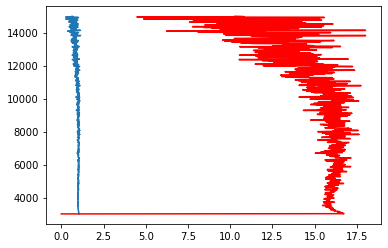

In [396]:
fig, ax = plt.subplots()
ax.plot(X[206,:], mat_alt[206,:])
ax.plot(X3[206,:], mat_alt[206,:], color='r')

In [402]:
X = np.vstack((X.ravel(), mat_alt.ravel(), X3.ravel()))
X = X.T
Y = Y.ravel()
print(X.shape)


(2235602, 3)


In [425]:
Yinput = Y[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(X[:,2]), ~np.isnan(Y))]
Xinput = X[np.logical_and(~np.isnan(X[:,0]), ~np.isnan(X[:,2]), ~np.isnan(Y)),:]

# generate Decision Tree model
from sklearn.tree import DecisionTreeRegressor as DTR
tree = DTR(min_samples_leaf=5)
tree.fit(Xinput,Yinput)

DecisionTreeRegressor(min_samples_leaf=5)

In [426]:
# generate Data Test 

Xt = alsr355[list_notrandom50, :]
Yt = alsr532[list_notrandom50, :]
mat_alt = np.tile(xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')['range'].values, (Xt.shape[0], 1))
X3t = np.zeros(mat_alt.shape)
print(X3t.shape)
X3t[0,:] = np.nan
for j in tqdm(range(1, mat_alt.shape[1])):
    X3t[:,j] = Xt[:,j-1] + Xt[:,j]*(mat_alt[:,j] - mat_alt[:,j-1])
print(X3t)

Xt = np.vstack((Xt.ravel(), mat_alt.ravel(), X3t.ravel()))
Xt = Xt.T
Yt = Yt.ravel()
Xtests = Xt[np.logical_and(~np.isnan(Xt[:,0]), ~np.isnan(Xt[:,2]), ~np.isnan(Yt)),:]
Ytests = Yt[np.logical_and(~np.isnan(Xt[:,0]), ~np.isnan(Xt[:,2]), ~np.isnan(Yt))]


100%|██████████| 798/798 [00:00<00:00, 10141.39it/s]

(2799, 799)
[[         nan  12.40138864  12.53360169 ...  19.07680287  19.18095708
   18.94359141]
 [  0.          16.85387966  16.65785194 ...   3.97187637   9.86663377
   25.18176084]
 [  0.          16.7157585   16.74386358 ...  18.54534576  14.8751189
   27.77058913]
 ...
 [  0.          16.73422839  16.47684954 ...   8.79794536   1.82165201
    1.6056163 ]
 [  0.          16.67269727  16.65386609 ...   3.30495964   5.34538957
   12.98659681]
 [  0.          16.59313771  16.6524946  ...  22.88664079 -15.02083815
   -9.70264995]]


In [433]:
Ypred = tree.predict(Xtests)
residus_y_test3features = Ytests - Ypred

(array([[0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
          8. ,   8.4,   8.8,   9.2,   9.6,  10. ,  10.4,  10.8,  11.2,
         11.6,  12. ,  12.4,  12.8,  13.2,  13.6,  14. ,  14.4,  14.8,
         15.2,  15.6,  16. ,  16.4,  16.8,  17.2,  17.6,  18. ,  18.4,
         18.8,  19.2,  19.6,  20. ,  20.4,  20.8,  21.2,  21.6,  22. ,
         22.4,  22.8,  23.2,  23.6,  24. ,  24.4,  24.8,  25.2,  25.6,
         26. ,  26.4,  26.8,  27.2,  27.6

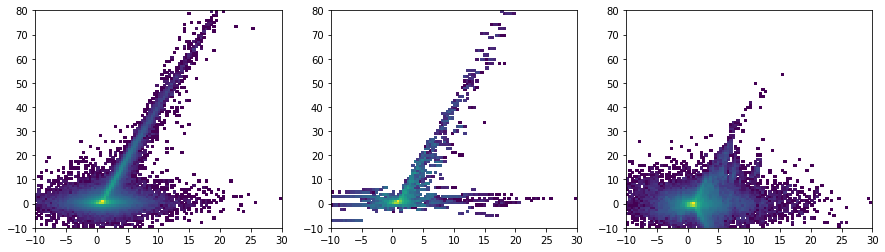

In [434]:
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))
ax.hist2d(Xtests[:,0], Ytests, bins=100, range=[[-10,30], [-10,80]], norm=LogNorm())
ax2.hist2d(Xtests[:,0], Ypred, bins=100, range=[[-10,30], [-10,80]], norm=LogNorm())
ax3.hist2d(Xtests[:,0], residus_y_test3features, bins=100, range=[[-10,30], [-10,80]], norm=LogNorm())

In [430]:
# évaluation 
residus_y_test3features.describe()

,0
count,1.782568e+06
mean,3.920059e-02
std,1.364246e+00
min,-7.062321e+01
25%,-8.104956e-02
50%,-2.324981e-03
75%,6.428314e-02
max,3.109002e+02


In [36]:
dtrea=xr.open_dataset('/bdd/ERA5/NETCDF/GLOBAL_025/4xdaily/AN_PL/2013/ta.201312.aphe5.GLOBAL_025.nc')

In [42]:
print(dtrea)
longitude_selected = [65.5, 65.75, 66, 66.25, 66.5] #je prends au hasard pour l'exemple
ta = dtrea['ta'].sel(longitude =  longitude_selected)
print(ta)


<xarray.Dataset>
Dimensions:    (latitude: 721, level: 37, longitude: 1440, time: 124)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2013-12-01 ... 2013-12-31T18:00:00
Data variables:
    ta         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:                 CF-1.6
    title:                       ERA5 reanalysis
    data_type:                   4xdaily fields analysis
    grid_resolution_in_degrees:  0.25
    source:                      credit: ECMWF, COPERNICUS Climate Change Ser...
    NCO:                         "4.6.1"
    history:                     Wed Apr 18 09:21:32 2018: ncatted -a history...
<xarray.DataArray 'ta' (time: 124, level: 37, latitude: 721, longitude: 5)>
[16539740 values with dtype=float3

In [43]:
ta.to_netcdf('/home/nmpnguyen/test_ta.nc')